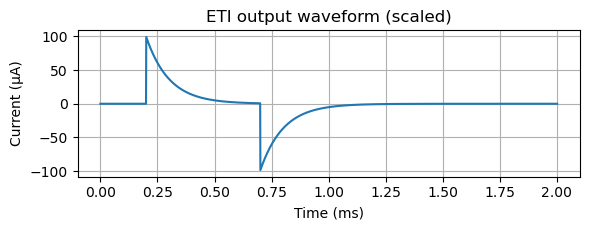

[main] Searching threshold for diameter 0.8 µm ...
[threshold_search] No AP for diameter 0.8 up to factor 50.0.
  -> No threshold found for diameter 0.8 within range.
[main] Searching threshold for diameter 1.5 µm ...
[threshold_search] No AP for diameter 1.5 up to factor 50.0.
  -> No threshold found for diameter 1.5 within range.
[main] Searching threshold for diameter 2.0 µm ...
[threshold_search] No AP for diameter 2.0 up to factor 50.0.
  -> No threshold found for diameter 2.0 within range.
[main] Searching threshold for diameter 5.7 µm ...
[threshold_search] No AP for diameter 5.7 up to factor 50.0.
  -> No threshold found for diameter 5.7 within range.
[main] Searching threshold for diameter 10.0 µm ...
[threshold_search] No AP for diameter 10.0 up to factor 50.0.
  -> No threshold found for diameter 10.0 within range.


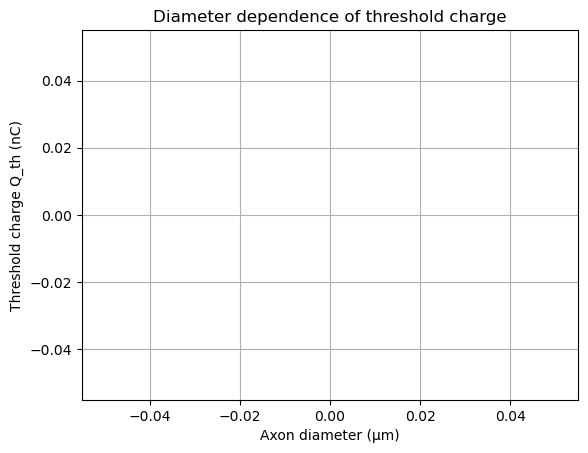


Results (diameter µm -> A_th, Q_th (nC)):
   0.8 µm : A_th = None, Q_th = None nC
   1.5 µm : A_th = None, Q_th = None nC
   2.0 µm : A_th = None, Q_th = None nC
   5.7 µm : A_th = None, Q_th = None nC
  10.0 µm : A_th = None, Q_th = None nC


In [57]:
# full_pipeline_etiv_neuron.py
# 依赖: numpy, matplotlib, neuron
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
h.load_file('stdrun.hoc')

# --------------------------
# 0) ETI model: generate_eti_current (Randles-like)
# --------------------------
def generate_eti_current(V_app_func, tvec, R_s=100.0, R_ct=1e6, C_dl=1e-6):
    """
    Generate current through a Randles-like ETI for applied voltage V_app(t).
    - V_app_func: callable t->V (volts), t in seconds
    - tvec: 1D numpy time vector (seconds)
    - R_s: series resistance (Ohm)
    - R_ct: charge transfer resistance (Ohm)
    - C_dl: double-layer capacitance (Farads)
    Returns I(t) (Amps) same length as tvec.
    """
    dt = float(tvec[1] - tvec[0])
    N = len(tvec)
    Vp = np.zeros(N)
    I = np.zeros(N)
    for n in range(N-1):
        V_app_next = V_app_func(tvec[n+1])
        a = C_dl/dt + 1.0/R_ct + 1.0/R_s
        b = C_dl*Vp[n]/dt + V_app_next/R_s
        Vp_next = b / a
        I_next = (V_app_next - Vp_next)/R_s
        Vp[n+1] = Vp_next
        I[n+1] = I_next
    return I

def rectangular_pulse(V0, t_on, t_off):
    def Vfunc(t):
        return V0 if (t >= t_on and t <= t_off) else 0.0
    return Vfunc

# --------------------------
# 1) Safety prepare function: units, scaling, clipping
# --------------------------
def prepare_waveform_for_neuron(t_s, I_A, I_target_A=100e-6, hard_clip_A=200e-6):
    """
    Convert to NEURON units and scale/clip safely.
    - t_s: seconds
    - I_A: Amps
    - I_target_A: desired peak current (A)
    - hard_clip_A: absolute safety clip (A)
    Returns: t_ms (ms), I_nA (nA)
    """
    t_ms = t_s * 1e3
    I_nA = I_A * 1e9
    peak_nA = np.max(np.abs(I_nA))
    hard_clip_nA = hard_clip_A * 1e9
    target_nA = I_target_A * 1e9

    if peak_nA == 0:
        raise RuntimeError("Waveform peak is zero.")
    if peak_nA > hard_clip_nA:
        raise RuntimeError(f"Waveform peak too large: {peak_nA:.3e} nA (>{hard_clip_nA:.3e} nA). Aborting.")
    if peak_nA > target_nA:
        scale = target_nA / peak_nA
        I_nA = I_nA * scale
        print(f"[prepare] scaled waveform by {scale:.3e} -> target peak {target_nA:.1f} nA")
    I_nA = np.clip(I_nA, -hard_clip_nA, hard_clip_nA)
    return t_ms, I_nA

# --------------------------
# 2) MRG-like axon constructor (diameter-dependent)
# --------------------------
def make_mrg_like_axon(num_nodes=21, diameter_um=5.7):
    """
    Build a more realistic diameter-dependent myelinated axon.
    Returns list of node sections.
    """
    nodes = []
    internodes = []

    # geometry scaling heuristics (tune as needed)
    node_length_um = max(0.5, 1.0 * (diameter_um / 5.7))
    internode_length_um = max(200.0, 1000.0 * (diameter_um / 5.7))
    Ra = 100.0  # ohm*cm
    cm_node = 1.0    # uF/cm2
    cm_internode = 0.04  # uF/cm2 (myelin)
    g_pas_internode = 1e-5

    for i in range(num_nodes):
        node = h.Section(name=f'node_{i}')
        node.L = node_length_um
        node.diam = diameter_um
        node.nseg = 1
        node.Ra = Ra
        node.cm = cm_node
        node.insert('hh')
        # gently scale hh conductances with diameter (optional)
        try:
            node.gnabar_hh = getattr(node, 'gnabar_hh', 0.12) * (diameter_um / 5.7)
            node.gkbar_hh = getattr(node, 'gkbar_hh', 0.036) * (diameter_um / 5.7)
        except Exception:
            pass
        nodes.append(node)

        if i < num_nodes - 1:
            intn = h.Section(name=f'int_{i}')
            intn.L = internode_length_um
            intn.diam = diameter_um
            intn.nseg = 1
            intn.Ra = Ra
            intn.cm = cm_internode
            intn.insert('pas')
            intn(0.5).pas.g = g_pas_internode
            intn(0.5).pas.e = -80
            internodes.append(intn)

    # connect: child.connect(parent, parent_x)
    for i in range(num_nodes - 1):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)

    return nodes

# --------------------------
# 3) Injection helper: play waveform into IClamp.amp
# --------------------------
def inject_waveform_to_node(nodes, t_ms, I_nA_array):
    stim_site = nodes[0](0.5)
    stim = h.IClamp(stim_site)
    stim.delay = 0.0
    stim.dur = 1e9
    vec_t = h.Vector(t_ms.tolist())
    vec_i = h.Vector(I_nA_array.tolist())
    vec_i.play(stim._ref_amp, vec_t)
    return stim, vec_t, vec_i

# --------------------------
# 4) AP detection: robust (Vm + dv/dt)
# --------------------------
def detect_AP(v_vec, t_vec, vm_threshold=0.0, dvdt_threshold=15.0):
    v = np.array(v_vec)
    t = np.array(t_vec)
    if len(v) < 3:
        return False
    vm_max = np.max(v)
    dv = np.diff(v) / np.diff(t)  # mV / ms
    dvdt_max = np.nanmax(dv)
    return (vm_max > vm_threshold) or (dvdt_max > dvdt_threshold)

# --------------------------
# 5) Single test run (build fresh axon, inject scaled waveform, run, record distal node)
# --------------------------
def run_single_test(diameter_um, t_ms, I_nA_array, detect_node_idx=5, tstop_offset_ms=5.0):
    nodes = make_mrg_like_axon(num_nodes=21, diameter_um=diameter_um)
    stim, vec_t, vec_i = inject_waveform_to_node(nodes, t_ms, I_nA_array)
    rec_t = h.Vector(); rec_v = h.Vector()
    rec_t.record(h._ref_t)
    idx = min(detect_node_idx, len(nodes) - 1)
    rec_v.record(nodes[idx](0.5)._ref_v)
    h.dt = 0.02
    h.finitialize(-65.0)
    h.continuerun(t_ms[-1] + tstop_offset_ms)
    time = np.array(rec_t)
    v = np.array(rec_v)
    ap = detect_AP(v, time)
    return ap, time, v

# --------------------------
# 6) Threshold search: exponential bound finding + bisection
# --------------------------
def threshold_search(diameter_um, t_ms, base_I_nA, detect_node_idx=5, max_factor=100.0, bisect_iters=12, dvdt_threshold=15.0):
    """
    Find scaling A such that A * base_I_nA triggers AP for a fresh axon of given diameter.
    Returns A_th (scaling) and Q_th (C).
    If not found up to max_factor, returns (None, None).
    """
    # Exponential search for an upper bound
    A = 0.5
    found = False
    while A <= max_factor:
        I_test = base_I_nA * A
        ap, _, _ = run_single_test(diameter_um, t_ms, I_test, detect_node_idx=detect_node_idx)
        if ap:
            found = True
            hi = A
            lo = A / 2.0
            break
        A *= 2.0
    if not found:
        print(f"[threshold_search] No AP for diameter {diameter_um} up to factor {max_factor}.")
        return None, None

    # Bisection
    for _ in range(bisect_iters):
        mid = 0.5 * (lo + hi)
        I_test = base_I_nA * mid
        ap, _, _ = run_single_test(diameter_um, t_ms, I_test, detect_node_idx=detect_node_idx)
        if ap:
            hi = mid
        else:
            lo = mid
        if hi > 0 and (hi - lo) / hi < 1e-2:
            break

    A_th = hi
    # compute Q_th: base_I_nA is nA; convert to A: *1e-9. t in seconds
    I_A_unit = base_I_nA * 1e-9
    Q_th = np.trapezoid(I_A_unit * A_th, t)  # t is seconds
    return A_th, Q_th

# --------------------------
# 7) Main: build ETI waveform, prepare, scan diameters
# --------------------------
if __name__ == "__main__":
    # 7.1 ETI / stimulus parameters
    V0 = 1e-2  # V (template)
    t_total = 0.002
    dt = 1e-6
    t = np.arange(0, t_total + dt, dt)
    t_on = 0.0002
    t_off = 0.0007
    Vfunc = rectangular_pulse(V0, t_on, t_off)

    R_s = 100.0
    R_ct = 1e6
    C_dl = 1e-6

    # generate ETI current (A)
    I_raw = generate_eti_current(Vfunc, t, R_s=R_s, R_ct=R_ct, C_dl=C_dl)

    # 7.2 prepare for NEURON: target peak (A)
    I_target = 200e-6  # target peak 100 µA
    t_ms, I_nA = prepare_waveform_for_neuron(t, I_raw, I_target_A=I_target, hard_clip_A=200e-6)

    # quick plot of waveform in µA
    plt.figure(figsize=(6,2.4))
    plt.plot(t_ms, I_nA * 1e-3)
    plt.xlabel("Time (ms)"); plt.ylabel("Current (µA)")
    plt.title("ETI output waveform (scaled)"); plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 7.3 diameters to test
    diameters = [0.8, 1.5, 2.0, 5.7, 10.0]  # µm (reduce list for speed)
    results = {}
    for d in diameters:
        print(f"[main] Searching threshold for diameter {d} µm ...")
        A_th, Q_th = threshold_search(d, t_ms, I_nA, detect_node_idx=5, max_factor=50.0, bisect_iters=12)
        if A_th is None:
            print(f"  -> No threshold found for diameter {d} within range.")
            results[d] = {'A_th': None, 'Q_th': None}
        else:
            print(f"  -> A_th={A_th:.3f}, Q_th={Q_th:.3e} C")
            results[d] = {'A_th': A_th, 'Q_th': Q_th}

    # 7.4 plot Q_th vs diameter (nC)
    ds = sorted(results.keys())
    qvals = [results[d]['Q_th']*1e9 if results[d]['Q_th'] is not None else np.nan for d in ds]
    plt.figure()
    plt.plot(ds, qvals, 'o-')
    plt.xlabel("Axon diameter (µm)")
    plt.ylabel("Threshold charge Q_th (nC)")
    plt.title("Diameter dependence of threshold charge")
    plt.grid(True)
    plt.show()

    # print table
    print("\nResults (diameter µm -> A_th, Q_th (nC)):")
    for d in ds:
        a = results[d]['A_th']
        q = results[d]['Q_th']
        print(f" {d:5.1f} µm : A_th = {a}, Q_th = { (q*1e9) if q is not None else None } nC")


In [59]:
# debug_excitation.py
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
h.load_file('stdrun.hoc')

# Reuse or redefine a simplified axon builder but with controllable internode length and hh scaling
def make_test_axon(num_nodes=21, diameter_um=5.7, node_length_um=2.0, internode_length_um=200.0, hh_scale=1.0):
    nodes = []
    internodes = []
    Ra = 100.0
    cm_node = 1.0
    cm_int = 0.04
    g_pas_int = 1e-5
    for i in range(num_nodes):
        node = h.Section()
        node.L = node_length_um
        node.diam = diameter_um
        node.nseg = 1
        node.Ra = Ra
        node.cm = cm_node
        node.insert('hh')
        # scale hh conductances via segment hh mechanism (gnabar, gkbar)
        for seg in node:
            try:
                seg.hh.gnabar = seg.hh.gnabar * hh_scale
                seg.hh.gkbar = seg.hh.gkbar * hh_scale
            except Exception:
                pass
        nodes.append(node)
        if i < num_nodes - 1:
            intn = h.Section()
            intn.L = internode_length_um
            intn.diam = diameter_um
            intn.nseg = 1
            intn.Ra = Ra
            intn.cm = cm_int
            intn.insert('pas')
            intn(0.5).pas.g = g_pas_int
            intn(0.5).pas.e = -80
            internodes.append(intn)
    for i in range(num_nodes - 1):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)
    return nodes

# Single rectangular DC pulse test using IClamp (nA)
def test_pulse_amplitudes(diameter_um, amps_nA, pulse_delay_ms=0.2, pulse_dur_ms=0.5, node_idx_record=5,
                          node_length_um=2.0, internode_length_um=200.0, hh_scale=1.0, tstop_extra=5.0):
    """
    amps_nA: iterable of amplitudes (nA) to test (positive injection)
    Returns: dict with keys 'amps','ap_detected' (bool per amp), and example traces for first successful amp.
    """
    results = {'amps': [], 'ap': [], 'first_success': None, 'first_trace': None}
    dt = 0.02  # ms
    for A in amps_nA:
        # build fresh axon
        nodes = make_test_axon(num_nodes=21, diameter_um=diameter_um, node_length_um=node_length_um,
                               internode_length_um=internode_length_um, hh_scale=hh_scale)
        stim = h.IClamp(nodes[0](0.5))
        stim.delay = pulse_delay_ms
        stim.dur = pulse_dur_ms
        stim.amp = A  # nA
        # record
        rt = h.Vector(); rv0 = h.Vector(); rvd = h.Vector()
        rt.record(h._ref_t)
        rv0.record(nodes[0](0.5)._ref_v)
        idx = min(node_idx_record, len(nodes)-1)
        rvd.record(nodes[idx](0.5)._ref_v)
        # run
        h.dt = dt
        h.finitialize(-65.0)
        h.continuerun(pulse_delay_ms + pulse_dur_ms + tstop_extra)
        time = np.array(rt)
        v0 = np.array(rv0)
        vd = np.array(rvd)
        # detect AP robustly
        def detect_ap(v, t, vm_thresh=0.0, dvdt_thresh=15.0):
            if len(v) < 3:
                return False
            vm_max = np.max(v)
            dv = np.diff(v)/np.diff(t)
            dvdt_max = np.nanmax(dv)
            return (vm_max > vm_thresh) or (dvdt_max > dvdt_thresh)
        ap_detected = detect_ap(vd, time)
        results['amps'].append(A)
        results['ap'].append(ap_detected)
        if ap_detected and results['first_success'] is None:
            results['first_success'] = A
            results['first_trace'] = {'time': time, 'v0': v0, 'vd': vd}
        # cleanup: delete references (NEURON objects get garbage-collected)
        del nodes, stim, rt, rv0, rvd
    return results

# Helper to run a quick sweep and plot
def run_quick_debug(diameters=[5.7], amps_nA=None):
    if amps_nA is None:
        amps_nA = np.concatenate([np.arange(50, 501, 50), np.arange(600, 5001, 400)])  # nA
        # e.g., 50 nA → 5 µA etc (note: 1000 nA = 1 µA)
    summary = {}
    for d in diameters:
        print(f"--- testing diameter {d} µm ---")
        # Try default internode length; if nothing, will try relaxed params later
        res = test_pulse_amplitudes(d, amps_nA, node_length_um=2.0, internode_length_um=200.0, hh_scale=1.0)
        print("amps tested (nA):", res['amps'])
        print("AP detected?:", res['ap'])
        print("first_success:", res['first_success'])
        summary[d] = res
        # plot first_success trace if exists
        if res['first_trace'] is not None:
            tr = res['first_trace']
            plt.figure(figsize=(7,3))
            plt.plot(tr['time'], tr['v0'], label='node0')
            plt.plot(tr['time'], tr['vd'], label=f'node{5}')
            plt.xlabel('Time (ms)'); plt.ylabel('Vm (mV)')
            plt.title(f'D = {d} µm, first success at {res["first_success"]} nA')
            plt.legend(); plt.grid(True); plt.show()
    return summary

# Run debug sweep for your diameters
if __name__ == "__main__":
    diameters_to_test = [0.8, 1.5, 2.0, 5.7, 10.0]
    summary = run_quick_debug(diameters=diameters_to_test)

    # If none had success, try relaxing model (shorter internodes, bigger hh)
    any_success = any([ (summary[d]['first_success'] is not None) for d in summary ])
    if not any_success:
        print("\nNo APs detected for default axon params. Retrying with relaxed propagation params...")
        summary_relaxed = {}
        for d in diameters_to_test:
            print(f"\nRelaxed test for D = {d} µm: internode_length=200 µm, hh_scale=2.5")
            res = test_pulse_amplitudes(d, np.concatenate([np.arange(50,1001,50), np.arange(1200,5001,400)]),
                                       node_length_um=2.0, internode_length_um=200.0, hh_scale=2.5)
            summary_relaxed[d] = res
            print("first_success:", res['first_success'])
            if res['first_trace'] is not None:
                tr = res['first_trace']
                plt.figure(figsize=(7,3))
                plt.plot(tr['time'], tr['v0'], label='node0')
                plt.plot(tr['time'], tr['vd'], label=f'node{5}')
                plt.xlabel('Time (ms)'); plt.ylabel('Vm (mV)')
                plt.title(f'Relaxed: D = {d} µm, first success at {res["first_success"]} nA')
                plt.legend(); plt.grid(True); plt.show()
        summary = summary_relaxed

    # Print final summary
    print("\nFINAL SUMMARY (first_success nA or None):")
    for d in summary:
        print(f" D={d} µm: first_success = {summary[d]['first_success']}")


--- testing diameter 0.8 µm ---
amps tested (nA): [np.int64(50), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(600), np.int64(1000), np.int64(1400), np.int64(1800), np.int64(2200), np.int64(2600), np.int64(3000), np.int64(3400), np.int64(3800), np.int64(4200), np.int64(4600), np.int64(5000)]
AP detected?: [np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_]
first_success: None
--- testing diameter 1.5 µm ---
amps tested (nA): [np.int64(50), np.int64(100), np.int64(150), np.int64(200), np.int64(250), np.int64(300), np.int64(350), np.int64(400), np.int64(450), np.int64(500), np.int64(600), np.int64(1000), np.int64(1400), np.int64(1800), np.int64(2200), np.int64(2600), np.int64(3000), np.int64(3400), np.in

STEP 1: single compartment HH excitability test
=== inspect inserted mechanisms and params ===
psection keys: ['point_processes', 'density_mechs', 'ions', 'morphology', 'nseg', 'Ra', 'cm', 'regions', 'species', 'name', 'hoc_internal_name', 'cell']
  L=20.0 µm, diam=20.0 µm, Ra=100.0, cm=1.0
  sec(0.5) has 'hh' attribute?: True
   hh.gnabar = 0.12
   hh.gkbar = 0.036
amp 0.01 nA -> ap:False, vm_max=-63.50 mV, dvdt_max=0.81 mV/ms
amp 0.02 nA -> ap:False, vm_max=-61.59 mV, dvdt_max=1.59 mV/ms
amp 0.05 nA -> ap:True, vm_max=38.11 mV, dvdt_max=271.94 mV/ms
amp 0.1 nA -> ap:True, vm_max=39.52 mV, dvdt_max=284.84 mV/ms
amp 0.2 nA -> ap:True, vm_max=40.57 mV, dvdt_max=294.33 mV/ms
amp 0.5 nA -> ap:True, vm_max=42.11 mV, dvdt_max=306.55 mV/ms
amp 1.0 nA -> ap:True, vm_max=43.83 mV, dvdt_max=318.08 mV/ms
amp 2.0 nA -> ap:True, vm_max=46.76 mV, dvdt_max=338.09 mV/ms


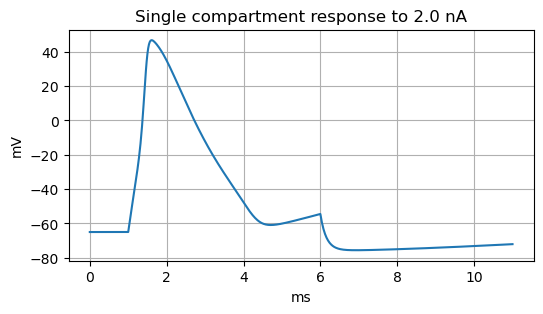


STEP 2: short axon propagation test (3 nodes) with moderate amp 0.5 nA
v0 max, v1 max, v2 max: -50.67635165629414 -51.34474848988349 -51.338769126166426


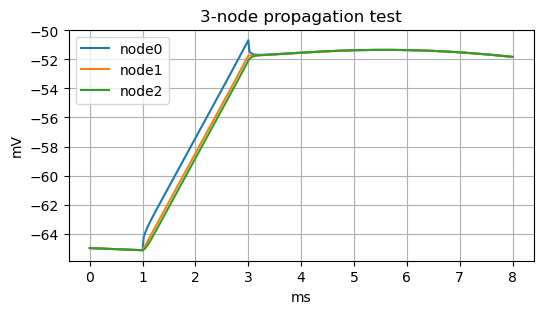


If STEP 1 failed (no AP on single compartment), try increasing hh density:
  - Re-run single_compartment_hh_test but after scaling hh conductances (e.g., multiply by 2-10).
If STEP 1 succeeded but STEP 2 shows no propagation to node2, try:
  - reduce internode_length_um (e.g., 50-200 µm)
  - increase hh density (hh_scale) at nodes
  - reduce node/internode geometry mismatch


In [3]:
# debug_hh_and_propagation.py
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
h.load_file('stdrun.hoc')

# --- helper: list mechanism params on a segment ---
# Robust single compartment HH test (replacement)
def inspect_section_mechanisms(sec):
    """Print what mechanisms exist on sec and try to read common hh params safely."""
    info = sec.psection()
    print("psection keys:", list(info.keys()))
    # Print basic electrical properties
    print(f"  L={sec.L} µm, diam={sec.diam} µm, Ra={getattr(sec,'Ra',None)}, cm={getattr(sec,'cm',None)}")
    # Attempt to list inserted mechanisms by parsing 'density' entries if present
    if 'density' in info and isinstance(info['density'], dict):
        mechs = list(info['density'].keys())
        print("  density mechanisms:", mechs)
    else:
        # fallback: try to probe common mechanism attributes
        try:
            has_hh = hasattr(sec(0.5), 'hh')
            print("  sec(0.5) has 'hh' attribute?:", has_hh)
        except Exception as e:
            print("  Could not check hh attribute:", e)

    # Try printing hh params if available
    try:
        hh = sec(0.5).hh
        # gnabar / gkbar attribute names can vary; try a list
        for attr in ['gnabar', 'gnabar_hh', 'gbar', 'gkbar', 'gkbar_hh']:
            if hasattr(hh, attr):
                print(f"   hh.{attr} = {getattr(hh, attr)}")
    except Exception as e:
        print("  Could not access sec(0.5).hh or its attributes:", e)

def single_compartment_hh_test(amp_list_nA=None, dur_ms=5.0, delay_ms=1.0):
    if amp_list_nA is None:
        amp_list_nA = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]  # nA
    sec = h.Section(name='soma_test')
    sec.L = 20.0; sec.diam = 20.0  # soma-like
    sec.nseg = 1
    sec.insert('hh')
    sec.Ra = 100.0
    sec.cm = 1.0

    print("=== inspect inserted mechanisms and params ===")
    inspect_section_mechanisms(sec)

    # Recording containers (recreated each amp to avoid stale data)
    results = {}
    for amp in amp_list_nA:
        rt = h.Vector(); rv = h.Vector()
        rt.record(h._ref_t)
        rv.record(sec(0.5)._ref_v)
        stim = h.IClamp(sec(0.5))
        stim.delay = delay_ms
        stim.dur = dur_ms
        stim.amp = amp
        h.dt = 0.02
        h.finitialize(-65.0)
        h.continuerun(delay_ms + dur_ms + 5.0)
        t = np.array(rt)
        v = np.array(rv)
        vm_max = v.max()
        dv = np.diff(v)/np.diff(t) if len(t)>1 else np.array([0.0])
        dvdt_max = np.nanmax(dv) if len(dv)>0 else 0.0
        ap = (vm_max > 0.0) or (dvdt_max > 15.0)
        results[amp] = {'ap': ap, 'vm_max': float(vm_max), 'dvdt_max': float(dvdt_max), 't': t.copy(), 'v': v.copy()}
        # cleanup
        del stim, rt, rv
    return results


# --- 2) Short axon propagation test (3 nodes) ---
def short_axon_propagation_test(amp_nA=0.5, node_length_um=2.0, internode_length_um=200.0, hh_scale=1.0):
    # build small 3-node axon: node0 - int0 - node1 - int1 - node2
    nodes = []
    internodes = []
    for i in range(3):
        node = h.Section(name=f'node{i}')
        node.L = node_length_um; node.diam = 5.7; node.nseg = 1
        node.insert('hh')
        # scale hh if possible
        try:
            node(0.5).hh.gnabar *= hh_scale
            node(0.5).hh.gkbar *= hh_scale
        except Exception:
            pass
        nodes.append(node)
        if i < 2:
            intn = h.Section(name=f'int{i}')
            intn.L = internode_length_um; intn.diam = 5.7; intn.nseg = 1
            intn.insert('pas'); intn(0.5).pas.g = 1e-5; intn(0.5).pas.e = -80
            internodes.append(intn)
    # connect
    internodes[0].connect(nodes[0], 1.0)
    nodes[1].connect(internodes[0],1.0)
    internodes[1].connect(nodes[1],1.0)
    nodes[2].connect(internodes[1],1.0)

    stim = h.IClamp(nodes[0](0.5))
    stim.delay = 1.0; stim.dur = 2.0; stim.amp = amp_nA

    rt = h.Vector(); v0 = h.Vector(); v1 = h.Vector(); v2 = h.Vector()
    rt.record(h._ref_t); v0.record(nodes[0](0.5)._ref_v); v1.record(nodes[1](0.5)._ref_v); v2.record(nodes[2](0.5)._ref_v)
    h.dt = 0.02
    h.finitialize(-65.0)
    h.continuerun(1.0 + 2.0 + 5.0)
    t = np.array(rt); vv0 = np.array(v0); vv1 = np.array(v1); vv2 = np.array(v2)
    return {'t': t, 'v0': vv0, 'v1': vv1, 'v2': vv2}

# --- RUN DIAGNOSTICS ---
if __name__ == "__main__":
    print("STEP 1: single compartment HH excitability test")
    res = single_compartment_hh_test(amp_list_nA=[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0], dur_ms=5.0, delay_ms=1.0)
    for amp, info in res.items():
        print(f"amp {amp} nA -> ap:{info['ap']}, vm_max={info['vm_max']:.2f} mV, dvdt_max={info['dvdt_max']:.2f} mV/ms")
    # Plot response for the largest amp tested
    last_amp = list(res.keys())[-1]
    tr = res[last_amp]
    plt.figure(figsize=(6,3)); plt.plot(tr['t'], tr['v']); plt.title(f"Single compartment response to {last_amp} nA"); plt.xlabel("ms"); plt.ylabel("mV"); plt.grid(True); plt.show()

    print("\nSTEP 2: short axon propagation test (3 nodes) with moderate amp 0.5 nA")
    out = short_axon_propagation_test(amp_nA=0.5, internode_length_um=200.0, hh_scale=1.0)
    print("v0 max, v1 max, v2 max:", out['v0'].max(), out['v1'].max(), out['v2'].max())
    plt.figure(figsize=(6,3)); plt.plot(out['t'], out['v0'], label='node0'); plt.plot(out['t'], out['v1'], label='node1'); plt.plot(out['t'], out['v2'], label='node2')
    plt.legend(); plt.xlabel('ms'); plt.ylabel('mV'); plt.title('3-node propagation test'); plt.grid(True); plt.show()

    print("\nIf STEP 1 failed (no AP on single compartment), try increasing hh density:")
    print("  - Re-run single_compartment_hh_test but after scaling hh conductances (e.g., multiply by 2-10).")
    print("If STEP 1 succeeded but STEP 2 shows no propagation to node2, try:")
    print("  - reduce internode_length_um (e.g., 50-200 µm)")
    print("  - increase hh density (hh_scale) at nodes")
    print("  - reduce node/internode geometry mismatch")


amp 0.5 nA -> v0max 50.57, v1max 49.08, v2max 49.08


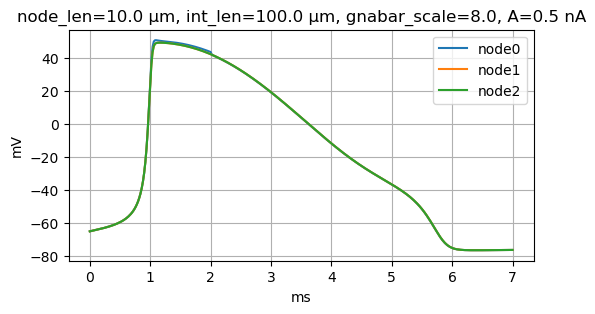

amp 1.0 nA -> v0max 52.63, v1max 49.08, v2max 49.08


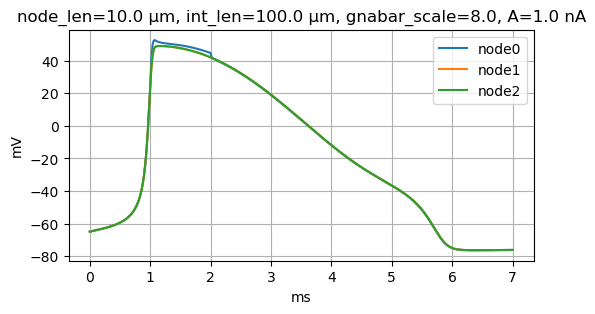

amp 2.0 nA -> v0max 57.66, v1max 49.08, v2max 49.08


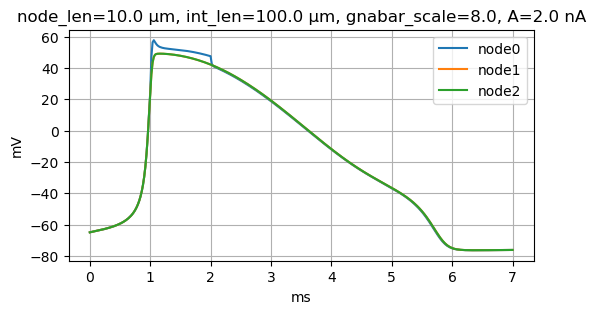

In [4]:
# 修复测试：增大节点面积与节点 Na 密度 + 缩短 internode
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

def make_test_axon_fixed(num_nodes=3, diameter_um=5.7, node_length_um=10.0, internode_length_um=100.0, hh_gnabar_scale=8.0):
    nodes = []
    internodes = []
    Ra = 100.0
    cm_node = 1.0
    cm_int = 0.04
    for i in range(num_nodes):
        node = h.Section(name=f'node{i}')
        node.L = node_length_um
        node.diam = diameter_um
        node.nseg = 1
        node.Ra = Ra
        node.cm = cm_node
        node.insert('hh')
        # attempt to scale hh gnabar/gkbar safely
        try:
            # attribute names differ by NEURON build; try common ones
            seg = node(0.5)
            if hasattr(seg, 'hh'):
                # gnabar attribute name might be 'gnabar' or 'gnabar_hh'
                if hasattr(seg.hh, 'gnabar'):
                    seg.hh.gnabar = seg.hh.gnabar * hh_gnabar_scale
                elif hasattr(seg.hh, 'gnabar_hh'):
                    seg.hh.gnabar_hh = seg.hh.gnabar_hh * hh_gnabar_scale
            # else ignore
        except Exception as e:
            print("Warning scaling hh:", e)
        nodes.append(node)
        if i < num_nodes - 1:
            intn = h.Section(name=f'int{i}')
            intn.L = internode_length_um
            intn.diam = diameter_um
            intn.nseg = 1
            intn.Ra = Ra
            intn.cm = cm_int
            intn.insert('pas')
            intn(0.5).pas.g = 1e-5
            intn(0.5).pas.e = -80
            internodes.append(intn)
    # connect chain: internodes[i] child connect to nodes[i]
    for i in range(num_nodes - 1):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)
    return nodes

def run_propagation_test(amps_nA=[0.5, 1.0, 2.0], node_len=10.0, int_len=100.0, gnabar_scale=8.0):
    for A in amps_nA:
        nodes = make_test_axon_fixed(num_nodes=3, diameter_um=5.7, node_length_um=node_len,
                                     internode_length_um=int_len, hh_gnabar_scale=gnabar_scale)
        stim = h.IClamp(nodes[0](0.5))
        stim.delay = 1.0; stim.dur = 1.0; stim.amp = A  # nA
        # record
        rt = h.Vector(); v0 = h.Vector(); v1 = h.Vector(); v2 = h.Vector()
        rt.record(h._ref_t); v0.record(nodes[0](0.5)._ref_v); v1.record(nodes[1](0.5)._ref_v); v2.record(nodes[2](0.5)._ref_v)
        h.dt = 0.02
        h.finitialize(-65.0)
        h.continuerun(1.0 + 1.0 + 5.0)
        t = np.array(rt); vv0 = np.array(v0); vv1 = np.array(v1); vv2 = np.array(v2)
        print(f"amp {A} nA -> v0max {vv0.max():.2f}, v1max {vv1.max():.2f}, v2max {vv2.max():.2f}")
        plt.figure(figsize=(6,3))
        plt.plot(t, vv0, label='node0')
        plt.plot(t, vv1, label='node1')
        plt.plot(t, vv2, label='node2')
        plt.title(f'node_len={node_len} µm, int_len={int_len} µm, gnabar_scale={gnabar_scale}, A={A} nA')
        plt.xlabel('ms'); plt.ylabel('mV'); plt.legend(); plt.grid(True); plt.show()
        del nodes, stim, rt, v0, v1, v2

# Run it:
run_propagation_test(amps_nA=[0.5, 1.0, 2.0], node_len=10.0, int_len=100.0, gnabar_scale=8.0)


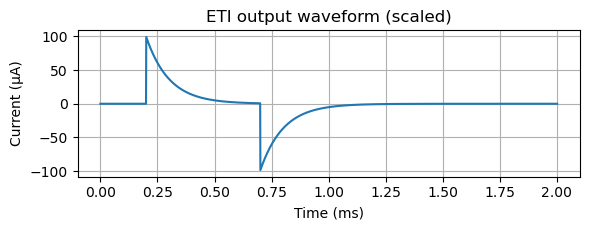

[main] Searching threshold for diameter 0.8 µm ...
  -> A_th = 0.252, Q_th = 1.266e-12 C
[main] Searching threshold for diameter 1.5 µm ...
  -> A_th = 0.252, Q_th = 1.266e-12 C
[main] Searching threshold for diameter 2.0 µm ...
  -> A_th = 0.252, Q_th = 1.266e-12 C
[main] Searching threshold for diameter 5.7 µm ...
  -> A_th = 0.252, Q_th = 1.266e-12 C
[main] Searching threshold for diameter 10.0 µm ...
  -> A_th = 0.252, Q_th = 1.266e-12 C


exp(41252.3) out of range, returning exp(700)
exp(22916.6) out of range, returning exp(700)
exp(20624.9) out of range, returning exp(700)
exp(41252.8) out of range, returning exp(700)
No more errno warnings during this execution


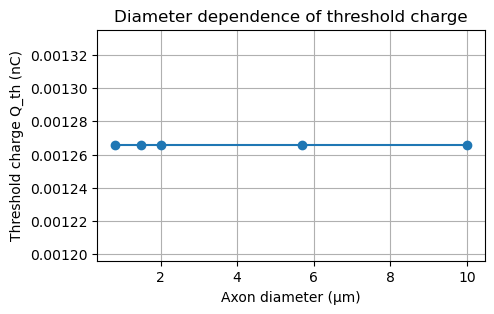


Results (diameter µm -> A_th, Q_th (nC)):
   0.8 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   1.5 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   2.0 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   5.7 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
  10.0 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC


In [6]:
# full_etiv_threshold.py
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
h.load_file('stdrun.hoc')

# -------------------------
# 0. ETI: Randles-like model -> generate current I(t) in A
# -------------------------
def rectangular_pulse(V0, t_on, t_off):
    def Vfunc(t):
        return V0 if (t >= t_on and t <= t_off) else 0.0
    return Vfunc

def generate_eti_current(V_app_func, tvec, R_s=100.0, R_ct=1e6, C_dl=1e-6):
    dt = float(tvec[1] - tvec[0])
    N = len(tvec)
    Vp = np.zeros(N)
    I = np.zeros(N)
    for n in range(N - 1):
        V_app_next = V_app_func(tvec[n + 1])
        a = C_dl / dt + 1.0 / R_ct + 1.0 / R_s
        b = C_dl * Vp[n] / dt + V_app_next / R_s
        Vp_next = b / a
        I_next = (V_app_next - Vp_next) / R_s
        Vp[n + 1] = Vp_next
        I[n + 1] = I_next
    return I

# -------------------------
# 1. Prepare waveform for NEURON: convert units, scale, clip
# -------------------------
def prepare_waveform_for_neuron(t_s, I_A, I_target_A=100e-6, hard_clip_A=200e-6):
    """
    t_s: seconds, I_A: amps -> returns t_ms (ms), I_nA (nA)
    Scales waveform proportionally so peak <= I_target_A, and errors if > hard_clip_A.
    """
    t_ms = t_s * 1e3
    I_nA = I_A * 1e9
    peak_nA = np.max(np.abs(I_nA))
    hard_clip_nA = hard_clip_A * 1e9
    target_nA = I_target_A * 1e9

    if peak_nA == 0:
        raise RuntimeError("Waveform peak is zero.")
    if peak_nA > hard_clip_nA:
        raise RuntimeError(f"Waveform peak too large: {peak_nA:.3e} nA (>{hard_clip_nA:.3e} nA). Aborting.")
    if peak_nA > target_nA:
        scale = target_nA / peak_nA
        I_nA = I_nA * scale
        print(f"[prepare] scaled waveform by {scale:.3e} -> target peak {target_nA:.1f} nA")
    I_nA = np.clip(I_nA, -hard_clip_nA, hard_clip_nA)
    return t_ms, I_nA

# -------------------------
# 2. Calibrated MRG-like axon builder
# -------------------------
def make_mrg_like_axon_calibrated(num_nodes=21, diameter_um=5.7,
                                  node_length_um=10.0, gnabar_scale=8.0,
                                  internode_length_scale=0.1):
    """
    Build axon with parameterized node length and gnabar scaling.
    internode_length_scale multiplies baseline internode (baseline 1000*(diam/5.7) µm).
    """
    nodes = []
    internodes = []
    Ra = 100.0
    cm_node = 1.0
    cm_int = 0.04
    g_pas_int = 1e-5

    base_internode_um = max(100.0, 1000.0 * (diameter_um / 5.7))
    internode_length_um = base_internode_um * internode_length_scale

    for i in range(num_nodes):
        node = h.Section(name=f'n{diameter_um}_{i}')
        node.L = node_length_um
        node.diam = diameter_um
        node.nseg = 1
        node.Ra = Ra
        node.cm = cm_node
        node.insert('hh')
        # scale hh gnabar if available
        try:
            seg = node(0.5)
            if hasattr(seg, 'hh'):
                if hasattr(seg.hh, 'gnabar'):
                    seg.hh.gnabar = seg.hh.gnabar * gnabar_scale
                elif hasattr(seg.hh, 'gnabar_hh'):
                    seg.hh.gnabar_hh = seg.hh.gnabar_hh * gnabar_scale
        except Exception:
            pass
        nodes.append(node)

        if i < num_nodes - 1:
            intn = h.Section(name=f'i{diameter_um}_{i}')
            intn.L = internode_length_um
            intn.diam = diameter_um
            intn.nseg = 1
            intn.Ra = Ra
            intn.cm = cm_int
            intn.insert('pas')
            intn(0.5).pas.g = g_pas_int
            intn(0.5).pas.e = -80
            internodes.append(intn)

    # connect chain
    for i in range(num_nodes - 1):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)

    return nodes

# helper factory
def nodes_factory_for_diameter(diameter_um, node_length_um=10.0, gnabar_scale=8.0, internode_scale=0.1):
    return lambda: make_mrg_like_axon_calibrated(num_nodes=21,
                                                diameter_um=diameter_um,
                                                node_length_um=node_length_um,
                                                gnabar_scale=gnabar_scale,
                                                internode_length_scale=internode_scale)

# -------------------------
# 3. Inject waveform into fresh axon and detect AP
# -------------------------
def run_single_test_factory(nodes_factory, t_ms, I_nA_array, detect_node_idx=5, tstop_offset_ms=5.0):
    """
    Build fresh nodes via factory, inject waveform I_nA_array (nA), run and detect AP at detect_node_idx.
    Returns (ap_bool, time_array_ms, voltage_array_mV_at_detect_node).
    """
    nodes = nodes_factory()
    stim_site = nodes[0](0.5)
    stim = h.IClamp(stim_site)
    stim.delay = 0.0
    stim.dur = 1e9
    vec_t = h.Vector(t_ms.tolist())
    vec_i = h.Vector(I_nA_array.tolist())
    vec_i.play(stim._ref_amp, vec_t)

    rec_t = h.Vector(); rec_v = h.Vector()
    rec_t.record(h._ref_t)
    idx = min(detect_node_idx, len(nodes) - 1)
    rec_v.record(nodes[idx](0.5)._ref_v)

    h.dt = 0.02
    h.finitialize(-65.0)
    h.continuerun(t_ms[-1] + tstop_offset_ms)

    time = np.array(rec_t)
    v = np.array(rec_v)
    # detection: Vm peak or dv/dt
    vm_max = np.max(v) if len(v) > 0 else -999.0
    dv = np.diff(v) / np.diff(time) if len(time) > 1 else np.array([0.0])
    dvdt_max = np.nanmax(dv) if len(dv) > 0 else 0.0
    ap = (vm_max > 0.0) or (dvdt_max > 15.0)
    return ap, time, v

# -------------------------
# 4. Threshold search (exp upper bound + bisect)
# -------------------------
def threshold_search_with_factory(nodes_factory, t_ms, I_nA_unit, low=0.0, max_factor=200.0, tol=1e-2, detect_idx=5):
    """
    I_nA_unit: numpy array (nA) base waveform.
    Returns A_th (scaling) and Q_th (C). If not found within max_factor returns (None, None).
    """
    # exponential search for upper bound
    A = max(0.5, 1e-6 if low == 0 else low)
    found = False
    while A <= max_factor:
        I_test = I_nA_unit * A
        ap, _, _ = run_single_test_factory(nodes_factory, t_ms, I_test, detect_node_idx=detect_idx)
        if ap:
            found = True
            hi = A; lo = max(0.0, A/2.0)
            break
        A *= 2.0
    if not found:
        return None, None

    # bisect
    for _ in range(25):
        mid = 0.5 * (lo + hi)
        I_test = I_nA_unit * mid
        ap, _, _ = run_single_test_factory(nodes_factory, t_ms, I_test, detect_node_idx=detect_idx)
        if ap:
            hi = mid
        else:
            lo = mid
        if hi > 0 and (hi - lo) / hi < tol:
            break
    A_th = hi
    # compute Q_th (use global t in seconds if available), otherwise convert t_ms
    # I_nA_unit in nA -> to A multiply by 1e-9
    I_A_unit = I_nA_unit * 1e-9
    try:
        Q_th = np.trapezoid(I_A_unit * A_th, t)  # t (s) must be in namespace
    except Exception:
        Q_th = np.trapezoid(I_A_unit * A_th, np.array(t_ms) * 1e-3)
    return A_th, Q_th

# -------------------------
# 5. Main: generate waveform, prepare, run searches
# -------------------------
if __name__ == "__main__":
    # --- ETI pulse/time parameters (customize here) ---
    t_total = 0.002   # s
    dt = 1e-6         # s
    t = np.arange(0, t_total + dt, dt)   # seconds

    V0 = 1e-2         # V (template). adjust up if needed.
    t_on = 0.0002
    t_off = 0.0007
    Vfunc = rectangular_pulse(V0, t_on, t_off)

    # ETI params (tune R_s, R_ct, C_dl to explore effect)
    R_s = 100.0
    R_ct = 1e6
    C_dl = 1e-6

    # generate I_raw (A)
    I_raw = generate_eti_current(Vfunc, t, R_s=R_s, R_ct=R_ct, C_dl=C_dl)

    # Prepare for NEURON: scale to target peak current (A). adjust I_target_A if desired.
    I_target_A = 100e-6  # 100 µA peak target
    t_ms, I_nA = prepare_waveform_for_neuron(t, I_raw, I_target_A=I_target_A, hard_clip_A=200e-6)

    # quick waveform plot (µA)
    plt.figure(figsize=(6,2.4))
    plt.plot(t_ms, I_nA * 1e-3)
    plt.xlabel("Time (ms)"); plt.ylabel("Current (µA)")
    plt.title("ETI output waveform (scaled)");
    plt.grid(True); plt.tight_layout(); plt.show()

    # scanning diameters (reduce list when debugging)
    diameters = [0.8, 1.5, 2.0, 5.7, 10.0]

    # calibrated params (these worked previously)
    node_len = 10.0         # µm
    gnabar_scale = 8.0
    internode_scale = 0.1   # base internode (1000*(diam/5.7)), scaled by 0.1 => ~100 µm

    results = {}
    for d in diameters:
        print(f"[main] Searching threshold for diameter {d} µm ...")
        factory = nodes_factory_for_diameter(d, node_length_um=node_len, gnabar_scale=gnabar_scale, internode_scale=internode_scale)
        A_th, Q_th = threshold_search_with_factory(factory, t_ms, I_nA, low=0.0, max_factor=200.0, tol=1e-2, detect_idx=5)
        if A_th is None:
            print(f"  -> No AP found up to max_factor for diameter {d}")
            results[d] = {'A_th': None, 'Q_th': None}
        else:
            print(f"  -> A_th = {A_th:.3f}, Q_th = {Q_th:.3e} C")
            results[d] = {'A_th': A_th, 'Q_th': Q_th}

    # plot Q_th vs diameter (nC)
    ds = sorted(results.keys())
    qvals = [results[d]['Q_th'] * 1e9 if results[d]['Q_th'] is not None else np.nan for d in ds]
    plt.figure(figsize=(5,3))
    plt.plot(ds, qvals, 'o-')
    plt.xlabel("Axon diameter (µm)")
    plt.ylabel("Threshold charge Q_th (nC)")
    plt.title("Diameter dependence of threshold charge")
    plt.grid(True); plt.show()

    # print table
    print("\nResults (diameter µm -> A_th, Q_th (nC)):")
    for d in ds:
        a = results[d]['A_th']
        q = results[d]['Q_th']
        print(f" {d:5.1f} µm : A_th = {a}, Q_th = { (q * 1e9) if q is not None else None } nC")


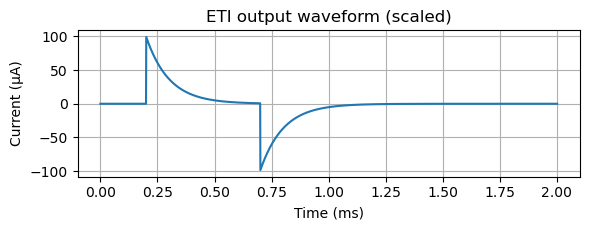

[main] Searching threshold for diameter 0.8 µm ...
  -> A_th = 0.251953, Q_th = 1.265634e-12 C
[main] Searching threshold for diameter 1.5 µm ...
  -> A_th = 0.251953, Q_th = 1.265634e-12 C
[main] Searching threshold for diameter 2.0 µm ...
  -> A_th = 0.251953, Q_th = 1.265634e-12 C
[main] Searching threshold for diameter 5.7 µm ...
  -> A_th = 0.251953, Q_th = 1.265634e-12 C
[main] Searching threshold for diameter 10.0 µm ...
  -> A_th = 0.251953, Q_th = 1.265634e-12 C


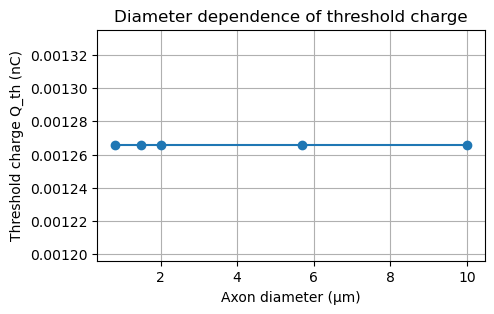


Results (diameter µm -> A_th, Q_th (nC)):
   0.8 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   1.5 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   2.0 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   5.7 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
  10.0 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC


In [8]:
# full_etiv_physio_threshold.py
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
h.load_file('stdrun.hoc')

# -------------------------
# ETI: pulse + Randles filter -> I(t) in A
# -------------------------
def rectangular_pulse(V0, t_on, t_off):
    def Vfunc(t):
        return V0 if (t >= t_on and t <= t_off) else 0.0
    return Vfunc

def generate_eti_current(V_app_func, tvec, R_s=100.0, R_ct=1e6, C_dl=1e-6):
    dt = float(tvec[1] - tvec[0])
    N = len(tvec)
    Vp = np.zeros(N)
    I = np.zeros(N)
    for n in range(N - 1):
        V_app_next = V_app_func(tvec[n + 1])
        a = C_dl / dt + 1.0 / R_ct + 1.0 / R_s
        b = C_dl * Vp[n] / dt + V_app_next / R_s
        Vp_next = b / a
        I_next = (V_app_next - Vp_next) / R_s
        Vp[n + 1] = Vp_next
        I[n + 1] = I_next
    return I

# -------------------------
# Prepare waveform for NEURON: unit conversion and safety scaling
# -------------------------
def prepare_waveform_for_neuron(t_s, I_A, I_target_A=100e-6, hard_clip_A=200e-6):
    """
    Convert seconds->ms and amps->nA, scale so peak <= I_target_A, clip at hard_clip_A.
    Returns t_ms (ms), I_nA (nA)
    """
    t_ms = t_s * 1e3
    I_nA = I_A * 1e9
    peak_nA = np.max(np.abs(I_nA))
    hard_clip_nA = hard_clip_A * 1e9
    target_nA = I_target_A * 1e9

    if peak_nA == 0:
        raise RuntimeError("Waveform peak is zero.")
    if peak_nA > hard_clip_nA:
        raise RuntimeError(f"Waveform peak too large: {peak_nA:.3e} nA (>{hard_clip_nA:.3e} nA). Aborting.")
    if peak_nA > target_nA:
        scale = target_nA / peak_nA
        I_nA = I_nA * scale
        print(f"[prepare] scaled waveform by {scale:.3e} -> target peak {target_nA:.1f} nA")
    I_nA = np.clip(I_nA, -hard_clip_nA, hard_clip_nA)
    return t_ms, I_nA

# -------------------------
# Physiologic, diameter-dependent MRG-like axon builder
# -------------------------
def make_mrg_like_axon_physio(num_nodes=21, diameter_um=5.7,
                              node_length_um_base=2.0,
                              gnabar_density=0.12,   # S/cm2 per-area baseline
                              gnabar_density_scale=6.0,  # global scale to reach excitability
                              internode_per_diam=100.0):  # µm internode per µm diameter
    """
    Build axon where:
      - node area ~ pi * diam * L
      - per-area gnabar is applied (scaled globally)
      - internode length scales roughly linearly with diameter
    Returns list of node sections.
    """
    nodes = []
    internodes = []
    Ra = 100.0          # ohm*cm
    cm_node = 1.0       # uF/cm2
    cm_int = 0.04       # uF/cm2 for internode
    g_pas_int = 1e-5

    # physio internode length: linear with diameter (with a floor)
    internode_length_um = max(50.0, internode_per_diam * diameter_um)

    # node length scale (weakly depends on diameter)
    node_length_um = max(1.0, node_length_um_base * (diameter_um / 5.7)**0.2)

    # total per-area gnabar applied on hh mechanism; user can tune gnabar_density_scale
    total_gnabar_per_area = gnabar_density * gnabar_density_scale

    for i in range(num_nodes):
        node = h.Section()
        node.L = node_length_um
        node.diam = diameter_um
        node.nseg = 1
        node.Ra = Ra
        node.cm = cm_node
        node.insert('hh')

        # set per-area gnabar on hh mechanism if available
        try:
            seg = node(0.5)
            if hasattr(seg, 'hh'):
                # attribute name might be 'gnabar' or 'gnabar_hh'
                if hasattr(seg.hh, 'gnabar'):
                    seg.hh.gnabar = total_gnabar_per_area
                elif hasattr(seg.hh, 'gnabar_hh'):
                    seg.hh.gnabar_hh = total_gnabar_per_area
        except Exception:
            pass

        nodes.append(node)

        if i < num_nodes - 1:
            intn = h.Section()
            intn.L = internode_length_um
            intn.diam = diameter_um
            intn.nseg = 1
            intn.Ra = Ra
            intn.cm = cm_int
            intn.insert('pas')
            intn(0.5).pas.g = g_pas_int
            intn(0.5).pas.e = -80
            internodes.append(intn)

    # connect chain (child.connect(parent, parent_x))
    for i in range(num_nodes - 1):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)

    return nodes

def nodes_factory_for_diameter_physio(diameter_um, node_length_um_base=2.0,
                                     gnabar_density=0.12, gnabar_density_scale=6.0,
                                     internode_per_diam=100.0):
    return lambda: make_mrg_like_axon_physio(num_nodes=21,
                                            diameter_um=diameter_um,
                                            node_length_um_base=node_length_um_base,
                                            gnabar_density=gnabar_density,
                                            gnabar_density_scale=gnabar_density_scale,
                                            internode_per_diam=internode_per_diam)

# -------------------------
# Inject waveform into fresh axon and detect AP
# -------------------------
def run_single_test_factory(nodes_factory, t_ms, I_nA_array, detect_node_idx=5, tstop_offset_ms=5.0):
    nodes = nodes_factory()
    stim_site = nodes[0](0.5)
    stim = h.IClamp(stim_site)
    stim.delay = 0.0
    stim.dur = 1e9
    vec_t = h.Vector(t_ms.tolist())
    vec_i = h.Vector(I_nA_array.tolist())
    vec_i.play(stim._ref_amp, vec_t)

    rec_t = h.Vector(); rec_v = h.Vector()
    rec_t.record(h._ref_t)
    idx = min(detect_node_idx, len(nodes) - 1)
    rec_v.record(nodes[idx](0.5)._ref_v)

    h.dt = 0.02
    h.finitialize(-65.0)
    h.continuerun(t_ms[-1] + tstop_offset_ms)

    time = np.array(rec_t)
    v = np.array(rec_v)
    vm_max = np.max(v) if len(v) > 0 else -999.0
    dv = np.diff(v) / np.diff(time) if len(time) > 1 else np.array([0.0])
    dvdt_max = np.nanmax(dv) if len(dv) > 0 else 0.0
    ap = (vm_max > 0.0) or (dvdt_max > 15.0)
    return ap, time, v

# -------------------------
# Threshold search (exponential bound + bisect)
# -------------------------
def threshold_search_with_factory(nodes_factory, t_ms, I_nA_unit, low=0.0, max_factor=200.0, tol=1e-2, detect_idx=5):
    """
    I_nA_unit: numpy array (nA) base waveform.
    Returns A_th and Q_th (C). If not found returns (None, None).
    """
    A = max(0.5, 1e-6 if low == 0 else low)
    found = False
    while A <= max_factor:
        I_test = I_nA_unit * A
        ap, _, _ = run_single_test_factory(nodes_factory, t_ms, I_test, detect_node_idx=detect_idx)
        if ap:
            found = True
            hi = A; lo = max(0.0, A/2.0)
            break
        A *= 2.0
    if not found:
        return None, None

    # bisection refine
    for _ in range(25):
        mid = 0.5 * (lo + hi)
        I_test = I_nA_unit * mid
        ap, _, _ = run_single_test_factory(nodes_factory, t_ms, I_test, detect_node_idx=detect_idx)
        if ap:
            hi = mid
        else:
            lo = mid
        if hi > 0 and (hi - lo) / hi < tol:
            break
    A_th = hi
    # compute Q_th: I_nA_unit (nA) -> A multiply 1e-9; integrate over t (seconds) if available
    I_A_unit = I_nA_unit * 1e-9
    try:
        Q_th = np.trapezoid(I_A_unit * A_th, t)  # assumes global t (s) exists
    except Exception:
        Q_th = np.trapezoid(I_A_unit * A_th, np.array(t_ms) * 1e-3)
    return A_th, Q_th

# -------------------------
# Main script: generate waveform and run threshold searches
# -------------------------
if __name__ == "__main__":
    # ---- time and pulse ----
    t_total = 0.002   # s
    dt = 1e-6         # s
    t = np.arange(0, t_total + dt, dt)   # seconds

    V0 = 1e-2         # V (10 mV template) — choose sensible value for your device
    t_on = 0.0002
    t_off = 0.0007
    Vfunc = rectangular_pulse(V0, t_on, t_off)

    # ETI circuit params
    R_s = 100.0
    R_ct = 1e6
    C_dl = 1e-6

    I_raw = generate_eti_current(Vfunc, t, R_s=R_s, R_ct=R_ct, C_dl=C_dl)  # A

    # prepare (scale to target peak)
    I_target_A = 100e-6  # target peak 100 µA; change if you want different baseline
    t_ms, I_nA = prepare_waveform_for_neuron(t, I_raw, I_target_A=I_target_A, hard_clip_A=200e-6)

    # quick waveform plot (µA)
    plt.figure(figsize=(6,2.4))
    plt.plot(t_ms, I_nA * 1e-3)
    plt.xlabel("Time (ms)"); plt.ylabel("Current (µA)")
    plt.title("ETI output waveform (scaled)")
    plt.grid(True); plt.tight_layout(); plt.show()

    # diameters to scan
    diameters = [0.8, 1.5, 2.0, 5.7, 10.0]   # µm (reduce for speed if needed)

    # physio builder params (tune these if needed)
    node_length_um_base = 2.0
    gnabar_density = 0.12
    gnabar_density_scale = 6.0    # global tuning; reduce if exp warnings appear
    internode_per_diam = 100.0    # µm internode per µm diameter
    detect_idx = 5

    results = {}
    for d in diameters:
        print(f"[main] Searching threshold for diameter {d} µm ...")
        factory = nodes_factory_for_diameter_physio(d,
                                                   node_length_um_base=node_length_um_base,
                                                   gnabar_density=gnabar_density,
                                                   gnabar_density_scale=gnabar_density_scale,
                                                   internode_per_diam=internode_per_diam)
        A_th, Q_th = threshold_search_with_factory(factory, t_ms, I_nA, low=0.0, max_factor=200.0, tol=1e-2, detect_idx=detect_idx)
        if A_th is None:
            print(f"  -> No AP found up to max_factor for diameter {d}")
            results[d] = {'A_th': None, 'Q_th': None}
        else:
            print(f"  -> A_th = {A_th:.6f}, Q_th = {Q_th:.6e} C")
            results[d] = {'A_th': A_th, 'Q_th': Q_th}

    # plot Q_th vs diameter (nC)
    ds = sorted(results.keys())
    qvals = [results[d]['Q_th'] * 1e9 if results[d]['Q_th'] is not None else np.nan for d in ds]
    plt.figure(figsize=(5,3))
    plt.plot(ds, qvals, 'o-')
    plt.xlabel("Axon diameter (µm)")
    plt.ylabel("Threshold charge Q_th (nC)")
    plt.title("Diameter dependence of threshold charge")
    plt.grid(True); plt.show()

    print("\nResults (diameter µm -> A_th, Q_th (nC)):")
    for d in ds:
        a = results[d]['A_th']
        q = results[d]['Q_th']
        print(f" {d:5.1f} µm : A_th = {a}, Q_th = { (q * 1e9) if q is not None else None } nC")


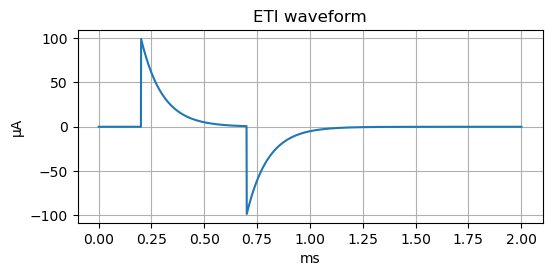


=== MODE1 (fixed internode or specified kwargs) ===
[mode1] diam 0.8: node_len 1.35 µm, internode 100.0 µm, nodal_area_cm2 3.394e-08, approx_total_gnabar 1.629e-08
  -> A_th=0.251953125, Q_th=0.001265633757208828 nC
[mode1] diam 1.5: node_len 1.53 µm, internode 100.0 µm, nodal_area_cm2 7.216e-08, approx_total_gnabar 3.464e-08
  -> A_th=0.251953125, Q_th=0.001265633757208828 nC
[mode1] diam 2.0: node_len 1.62 µm, internode 100.0 µm, nodal_area_cm2 1.019e-07, approx_total_gnabar 4.892e-08
  -> A_th=0.251953125, Q_th=0.001265633757208828 nC
[mode1] diam 5.7: node_len 2.00 µm, internode 100.0 µm, nodal_area_cm2 3.581e-07, approx_total_gnabar 1.719e-07
  -> A_th=0.251953125, Q_th=0.001265633757208828 nC
[mode1] diam 10.0: node_len 2.24 µm, internode 100.0 µm, nodal_area_cm2 7.031e-07, approx_total_gnabar 3.375e-07
  -> A_th=0.251953125, Q_th=0.001265633757208828 nC

=== MODE2 (internode scaled with diameter) ===
[mode2] diam 0.8: node_len 1.35 µm, internode 80.0 µm, nodal_area_cm2 3.394e-0

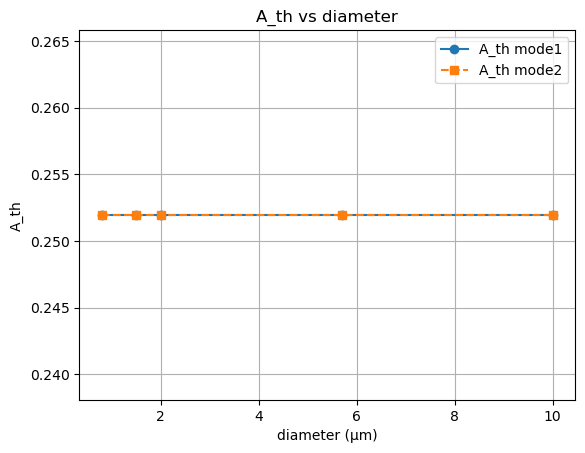

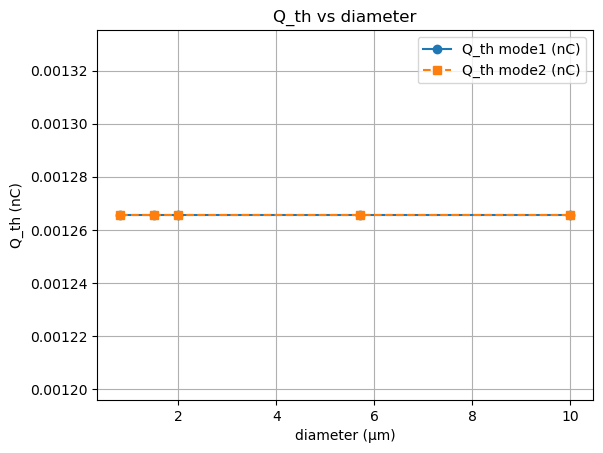


Finished. Results dictionary returned as 'results'.


In [11]:
# full_compare_physio2.py
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
h.load_file('stdrun.hoc')

# ------------------ ETI waveform (Randles) ------------------
def rectangular_pulse(V0, t_on, t_off):
    def Vfunc(t):
        return V0 if (t >= t_on and t <= t_off) else 0.0
    return Vfunc

def generate_eti_current(V_app_func, tvec, R_s=100.0, R_ct=1e6, C_dl=1e-6):
    dt = float(tvec[1] - tvec[0])
    N = len(tvec)
    Vp = np.zeros(N)
    I = np.zeros(N)
    for n in range(N - 1):
        V_app_next = V_app_func(tvec[n + 1])
        a = C_dl / dt + 1.0 / R_ct + 1.0 / R_s
        b = C_dl * Vp[n] / dt + V_app_next / R_s
        Vp_next = b / a
        I_next = (V_app_next - Vp_next) / R_s
        Vp[n + 1] = Vp_next
        I[n + 1] = I_next
    return I

def prepare_waveform_for_neuron(t_s, I_A, I_target_A=100e-6, hard_clip_A=200e-6):
    t_ms = t_s * 1e3
    I_nA = I_A * 1e9
    peak_nA = np.max(np.abs(I_nA))
    hard_clip_nA = hard_clip_A * 1e9
    target_nA = I_target_A * 1e9
    if peak_nA == 0:
        raise RuntimeError("Waveform peak is zero.")
    if peak_nA > hard_clip_nA:
        raise RuntimeError(f"Waveform peak too large: {peak_nA:.3e} nA (>{hard_clip_nA:.3e} nA).")
    if peak_nA > target_nA:
        scale = target_nA / peak_nA
        I_nA = I_nA * scale
        print(f"[prepare] scaled waveform by {scale:.3e} -> target peak {target_nA:.0f} nA")
    I_nA = np.clip(I_nA, -hard_clip_nA, hard_clip_nA)
    return t_ms, I_nA

# ------------------ physiologic2 axon builder ------------------
def make_mrg_like_axon_physio2(num_nodes=21, diameter_um=5.7,
                               node_length_um_base=2.0,
                               gnabar_density=0.12,   # S/cm2 per-area baseline
                               gnabar_density_scale=6.0,
                               internode_per_diam=100.0,
                               internode_fixed=None,
                               per_area_gnabar=True,
                               gnabar_beta=0.0):
    nodes = []
    internodes = []
    Ra = 100.0
    cm_node = 1.0
    cm_int = 0.04
    g_pas_int = 1e-5

    if internode_fixed is not None:
        internode_length_um = float(internode_fixed)
    else:
        internode_length_um = max(50.0, internode_per_diam * diameter_um)

    node_length_um = max(1.0, node_length_um_base * (diameter_um / 5.7)**0.2)

    diam_cm = diameter_um * 1e-4
    L_cm = node_length_um * 1e-4
    nodal_area_cm2 = np.pi * diam_cm * L_cm

    if per_area_gnabar:
        total_gnabar_S = gnabar_density * gnabar_density_scale * nodal_area_cm2
        per_area_value = gnabar_density * gnabar_density_scale
    else:
        total_gnabar_S = (diameter_um**gnabar_beta) * gnabar_density_scale
        per_area_value = gnabar_density_scale  # fallback for setting mech param

    for i in range(num_nodes):
        node = h.Section()
        node.L = node_length_um
        node.diam = diameter_um
        node.nseg = 1
        node.Ra = Ra
        node.cm = cm_node
        node.insert('hh')
        try:
            seg = node(0.5)
            if hasattr(seg, 'hh'):
                if hasattr(seg.hh, 'gnabar'):
                    seg.hh.gnabar = per_area_value
                elif hasattr(seg.hh, 'gnabar_hh'):
                    seg.hh.gnabar_hh = per_area_value
        except Exception:
            pass
        nodes.append(node)
        if i < num_nodes - 1:
            intn = h.Section()
            intn.L = internode_length_um
            intn.diam = diameter_um
            intn.nseg = 1
            intn.Ra = Ra
            intn.cm = cm_int
            intn.insert('pas')
            intn(0.5).pas.g = g_pas_int
            intn(0.5).pas.e = -80
            internodes.append(intn)

    for i in range(num_nodes - 1):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)

    diag = {'diameter_um': diameter_um, 'node_length_um': node_length_um,
            'internode_length_um': internode_length_um,
            'nodal_area_cm2': nodal_area_cm2, 'total_gnabar_S_approx': total_gnabar_S,
            'per_area_set': per_area_value}
    return nodes, diag

# ------------------ single-run injector + AP detect ------------------
def run_single_test_nodes(nodes, t_ms, I_nA_array, detect_node_idx=5, tstop_offset_ms=5.0):
    stim_site = nodes[0](0.5)
    stim = h.IClamp(stim_site)
    stim.delay = 0.0
    stim.dur = 1e9
    vec_t = h.Vector(t_ms.tolist())
    vec_i = h.Vector(I_nA_array.tolist())
    vec_i.play(stim._ref_amp, vec_t)
    rec_t = h.Vector(); rec_v = h.Vector()
    rec_t.record(h._ref_t)
    idx = min(detect_node_idx, len(nodes)-1)
    rec_v.record(nodes[idx](0.5)._ref_v)
    h.dt = 0.02
    h.finitialize(-65.0)
    h.continuerun(t_ms[-1] + tstop_offset_ms)
    time = np.array(rec_t); v = np.array(rec_v)
    vm_max = np.max(v) if len(v)>0 else -999.0
    dv = np.diff(v) / np.diff(time) if len(time)>1 else np.array([0.0])
    dvdt_max = np.nanmax(dv) if len(dv)>0 else 0.0
    ap = (vm_max > 0.0) or (dvdt_max > 15.0)
    return ap, time, v

# ------------------ threshold search for a factory-like builder ------------------
def threshold_search_factory_builder(builder_fn, t_ms, I_nA_unit, detect_idx=5, max_factor=200.0, tol=1e-2):
    # exponential search for upper bound
    A = 0.5
    found = False
    while A <= max_factor:
        nodes, _ = builder_fn()
        ap, _, _ = run_single_test_nodes(nodes, t_ms, I_nA_unit * A, detect_node_idx=detect_idx)
        if ap:
            found = True; hi=A; lo=A/2.0; break
        A *= 2.0
    if not found:
        return None, None
    # bisect
    for _ in range(25):
        mid = 0.5*(lo+hi)
        nodes, _ = builder_fn()
        ap, _, _ = run_single_test_nodes(nodes, t_ms, I_nA_unit * mid, detect_node_idx=detect_idx)
        if ap:
            hi = mid
        else:
            lo = mid
        if hi>0 and (hi-lo)/hi < tol:
            break
    A_th = hi
    I_A_unit = I_nA_unit * 1e-9
    try:
        Q_th = np.trapezoid(I_A_unit * A_th, t)  # use global t (s)
    except Exception:
        Q_th = np.trapezoid(I_A_unit * A_th, np.array(t_ms)*1e-3)
    return A_th, Q_th

# ------------------ Compare two modes over diameters ------------------
def compare_modes_and_search(t_ms, I_nA, diameters,
                             mode1_kwargs, mode2_kwargs, detect_idx=5):
    results = {'mode1':{}, 'mode2':{}}
    print("\n=== MODE1 (fixed internode or specified kwargs) ===")
    for d in diameters:
        # builder functions return (nodes,diag)
        builder1 = lambda d=d, kw=mode1_kwargs: make_mrg_like_axon_physio2(num_nodes=21, diameter_um=d, **kw)
        nodes, diag = builder1()
        print(f"[mode1] diam {d}: node_len {diag['node_length_um']:.2f} µm, internode {diag['internode_length_um']:.1f} µm, nodal_area_cm2 {diag['nodal_area_cm2']:.3e}, approx_total_gnabar {diag['total_gnabar_S_approx']:.3e}")
        # run threshold
        A_th, Q_th = threshold_search_factory_builder(builder1, t_ms, I_nA, detect_idx=detect_idx)
        results['mode1'][d] = {'A_th': A_th, 'Q_th': Q_th}
        print(f"  -> A_th={A_th}, Q_th={(Q_th*1e9) if Q_th is not None else None} nC")

    print("\n=== MODE2 (internode scaled with diameter) ===")
    for d in diameters:
        builder2 = lambda d=d, kw=mode2_kwargs: make_mrg_like_axon_physio2(num_nodes=21, diameter_um=d, **kw)
        nodes, diag = builder2()
        print(f"[mode2] diam {d}: node_len {diag['node_length_um']:.2f} µm, internode {diag['internode_length_um']:.1f} µm, nodal_area_cm2 {diag['nodal_area_cm2']:.3e}, approx_total_gnabar {diag['total_gnabar_S_approx']:.3e}")
        A_th, Q_th = threshold_search_factory_builder(builder2, t_ms, I_nA, detect_idx=detect_idx)
        results['mode2'][d] = {'A_th': A_th, 'Q_th': Q_th}
        print(f"  -> A_th={A_th}, Q_th={(Q_th*1e9) if Q_th is not None else None} nC")
    return results

# ------------------ MAIN: generate waveform and run comparisons ------------------
if __name__ == "__main__":
    # time & pulse
    t_total = 0.002; dt = 1e-6
    t = np.arange(0, t_total + dt, dt)  # seconds
    V0 = 1e-2; t_on = 0.0002; t_off = 0.0007
    Vfunc = rectangular_pulse(V0, t_on, t_off)
    I_raw = generate_eti_current(Vfunc, t, R_s=100.0, R_ct=1e6, C_dl=1e-6)  # A
    I_target_A = 100e-6
    t_ms, I_nA = prepare_waveform_for_neuron(t, I_raw, I_target_A=I_target_A)

    plt.figure(figsize=(6,2.5)); plt.plot(t_ms, I_nA*1e-3); plt.xlabel('ms'); plt.ylabel('µA'); plt.title('ETI waveform'); plt.grid(True); plt.show()

    # diameters to test
    diameters = [0.8, 1.5, 2.0, 5.7, 10.0]  # µm

    # MODE1: fixed internode (makes diameter effect more visible)
    mode1_kwargs = {'node_length_um_base':2.0, 'gnabar_density':0.12, 'gnabar_density_scale':4.0,
                    'internode_per_diam':100.0, 'internode_fixed':100.0, 'per_area_gnabar':True}

    # MODE2: internode scales with diameter (previous behavior)
    mode2_kwargs = {'node_length_um_base':2.0, 'gnabar_density':0.12, 'gnabar_density_scale':4.0,
                    'internode_per_diam':100.0, 'internode_fixed':None, 'per_area_gnabar':True}

    results = compare_modes_and_search(t_ms, I_nA, diameters, mode1_kwargs, mode2_kwargs, detect_idx=5)

    # plot A_th and Q_th for both modes
    ds = diameters
    A1 = [results['mode1'][d]['A_th'] if results['mode1'][d]['A_th'] is not None else np.nan for d in ds]
    A2 = [results['mode2'][d]['A_th'] if results['mode2'][d]['A_th'] is not None else np.nan for d in ds]
    Q1 = [results['mode1'][d]['Q_th']*1e9 if results['mode1'][d]['Q_th'] is not None else np.nan for d in ds]
    Q2 = [results['mode2'][d]['Q_th']*1e9 if results['mode2'][d]['Q_th'] is not None else np.nan for d in ds]

    plt.figure(); plt.plot(ds, A1, 'o-', label='A_th mode1'); plt.plot(ds, A2, 's--', label='A_th mode2')
    plt.xlabel('diameter (µm)'); plt.ylabel('A_th'); plt.legend(); plt.grid(True); plt.title('A_th vs diameter'); plt.show()

    plt.figure(); plt.plot(ds, Q1, 'o-', label='Q_th mode1 (nC)'); plt.plot(ds, Q2, 's--', label='Q_th mode2 (nC)')
    plt.xlabel('diameter (µm)'); plt.ylabel('Q_th (nC)'); plt.legend(); plt.grid(True); plt.title('Q_th vs diameter'); plt.show()

    print("\nFinished. Results dictionary returned as 'results'.")


In [12]:
# diagnostics.py -- run this after you have `t` (s), t_ms, I_nA
import numpy as np

def diag_nodal_vs_axial(diameters, node_length_um_base=2.0, internode_per_diam=100.0, internode_fixed=None, Ra_ohm_cm=100.0):
    print("diam  nodeL(um)  internode(um)  nodal_area(cm2)   approx_total_gnabar(S)   axial_cond_S_est   ratio_totalGnabar/axial")
    for d in diameters:
        # node length same scaling as earlier
        node_length_um = max(1.0, node_length_um_base * (d / 5.7)**0.2)
        if internode_fixed is not None:
            intn = float(internode_fixed)
        else:
            intn = max(50.0, internode_per_diam * d)
        # nodal area in cm^2 (cylindrical): pi * diam(cm) * L(cm)
        diam_cm = d * 1e-4
        L_cm = node_length_um * 1e-4
        nodal_area = np.pi * diam_cm * L_cm
        # using per-area gnabar value you used earlier
        per_area_gnabar = 0.12 * 4.0  # <--- set to current gnabar_density * gnabar_density_scale used in your runs; change if needed
        total_gnabar_S = per_area_gnabar * nodal_area  # S (approx)
        # axial conductance approximated as (sigma_axial * area) / length
        # axial resistance per length R_ax_per_cm = Ra_ohm_cm / area_cross_section(cm2)
        # axial conductance G_ax ≈ (area_cross_section / (Ra * length))
        r_cm = (d/2.0) * 1e-4
        area_cs = np.pi * r_cm**2
        length_cm = intn * 1e-4
        G_axial = area_cs / (Ra_ohm_cm * length_cm)  # S (approx)
        ratio = total_gnabar_S / (G_axial + 1e-30)
        print(f"{d:4.1f}   {node_length_um:6.2f}      {intn:8.1f}      {nodal_area:8.3e}        {total_gnabar_S:8.3e}          {G_axial:8.3e}      {ratio:8.3e}")

# run:
diameters = [0.8,1.5,2.0,5.7,10.0]
diag_nodal_vs_axial(diameters, node_length_um_base=2.0, internode_per_diam=100.0, internode_fixed=None, Ra_ohm_cm=100.0)


diam  nodeL(um)  internode(um)  nodal_area(cm2)   approx_total_gnabar(S)   axial_cond_S_est   ratio_totalGnabar/axial
 0.8     1.35          80.0      3.394e-08        1.629e-08          6.283e-09      2.593e+00
 1.5     1.53         150.0      7.216e-08        3.464e-08          1.178e-08      2.940e+00
 2.0     1.62         200.0      1.019e-07        4.892e-08          1.571e-08      3.114e+00
 5.7     2.00         570.0      3.581e-07        1.719e-07          4.477e-08      3.840e+00
10.0     2.24        1000.0      7.031e-07        3.375e-07          7.854e-08      4.297e+00


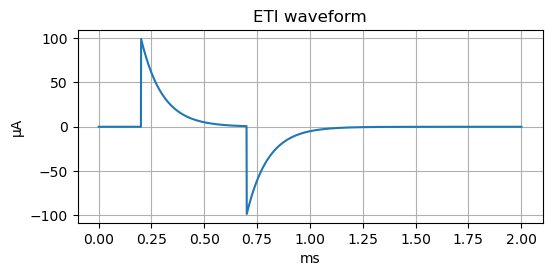


Running quick grid debug (shows first-success A if any)...

--- quick test diameter 0.8 µm (comp_power=1.0) ---
diag: {'diameter_um': 0.8, 'node_length_um': 1.3504329372916173, 'internode_length_um': 100.0, 'nodal_area_cm2': 3.394008155968825e-08, 'per_area_value': 0.384, 'total_gnabar_S_approx': 1.3032991318920288e-08}
  A=0.125 -> AP=True
  A=0.250 -> AP=True
  A=0.500 -> AP=True
  A=1.000 -> AP=True
  A=2.000 -> AP=True
  A=4.000 -> AP=True
  A=8.000 -> AP=True

--- quick test diameter 1.5 µm (comp_power=1.0) ---
diag: {'diameter_um': 1.5, 'node_length_um': 1.5313458162234919, 'internode_length_um': 100.0, 'nodal_area_cm2': 7.216297149529781e-08, 'per_area_value': 0.72, 'total_gnabar_S_approx': 5.195733947661443e-08}
  A=0.125 -> AP=True
  A=0.250 -> AP=True
  A=0.500 -> AP=True
  A=1.000 -> AP=True
  A=2.000 -> AP=True
  A=4.000 -> AP=True
  A=8.000 -> AP=True

--- quick test diameter 2.0 µm (comp_power=1.0) ---
diag: {'diameter_um': 2.0, 'node_length_um': 1.6220379974342756, 'int

/var/folders/8m/tx3t5tyj60b6c60kxmnfjtk40000gn/T/ipykernel_58214/3821707484.py:182: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Q_th = np.trapz(I_A_unit * A_th, t)  # t in seconds


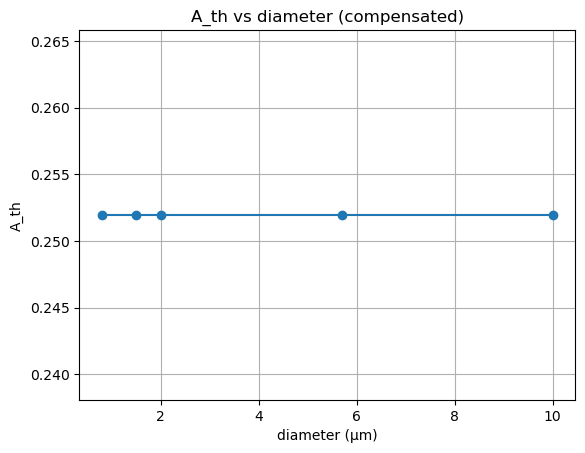

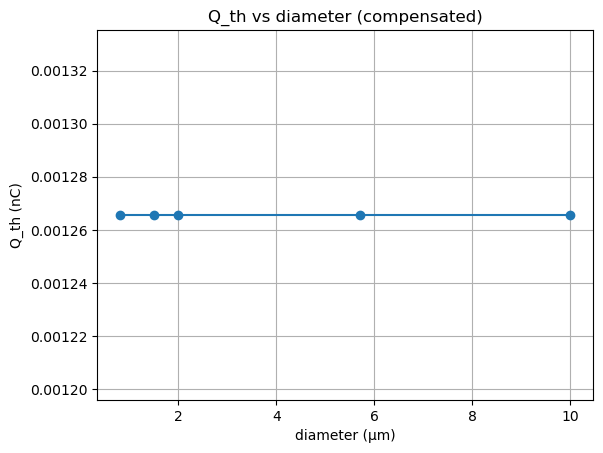


FINAL RESULTS:
   0.8 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   1.5 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   2.0 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
   5.7 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC
  10.0 µm : A_th = 0.251953125, Q_th = 0.001265633757208828 nC


In [13]:
# full_fixA_compensated.py
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui
h.load_file('stdrun.hoc')

# -------------------------
# 0. ETI waveform (Randles) -> I(t) in A
# -------------------------
def rectangular_pulse(V0, t_on, t_off):
    def Vfunc(t):
        return V0 if (t >= t_on and t <= t_off) else 0.0
    return Vfunc

def generate_eti_current(V_app_func, tvec, R_s=100.0, R_ct=1e6, C_dl=1e-6):
    dt = float(tvec[1] - tvec[0])
    N = len(tvec)
    Vp = np.zeros(N)
    I = np.zeros(N)
    for n in range(N - 1):
        V_app_next = V_app_func(tvec[n + 1])
        a = C_dl / dt + 1.0 / R_ct + 1.0 / R_s
        b = C_dl * Vp[n] / dt + V_app_next / R_s
        Vp_next = b / a
        I_next = (V_app_next - Vp_next) / R_s
        Vp[n + 1] = Vp_next
        I[n + 1] = I_next
    return I

def prepare_waveform_for_neuron(t_s, I_A, I_target_A=100e-6, hard_clip_A=200e-6):
    t_ms = t_s * 1e3
    I_nA = I_A * 1e9
    peak_nA = np.max(np.abs(I_nA))
    hard_clip_nA = hard_clip_A * 1e9
    target_nA = I_target_A * 1e9
    if peak_nA == 0:
        raise RuntimeError("Waveform peak is zero.")
    if peak_nA > hard_clip_nA:
        raise RuntimeError(f"Waveform peak too large: {peak_nA:.3e} nA (>{hard_clip_nA:.3e} nA).")
    if peak_nA > target_nA:
        scale = target_nA / peak_nA
        I_nA = I_nA * scale
        print(f"[prepare] scaled waveform by {scale:.3e} -> target peak {target_nA:.0f} nA")
    I_nA = np.clip(I_nA, -hard_clip_nA, hard_clip_n_n := hard_clip_nA) if False else np.clip(I_nA, -hard_clip_nA, hard_clip_nA)
    return t_ms, I_nA

# -------------------------
# 1. Builder A: compensated per-area gnabar ~ (base * d^compensation_power)
# -------------------------
def make_mrg_like_axon_compensated(num_nodes=21, diameter_um=5.7,
                                   node_length_um_base=2.0,
                                   gnabar_density=0.12, gnabar_density_scale=1.0,
                                   internode_per_diam=100.0,
                                   internode_fixed=None,
                                   compensation_power=1.0):
    """
    Build a simplified MRG-like axon where the per-area gnabar is multiplied by (diameter_um ** compensation_power).
    - compensation_power = 0 -> per-area constant
    - compensation_power = 1 -> per-area ~ d (so total nodal gnabar ~ d^2)
    """
    nodes = []
    internodes = []
    Ra = 100.0
    cm_node = 1.0
    cm_int = 0.04
    g_pas_int = 1e-5

    # internode length (either fixed or scale with diameter)
    if internode_fixed is not None:
        internode_length_um = float(internode_fixed)
    else:
        internode_length_um = max(50.0, internode_per_diam * diameter_um)

    # node length (weakly dependent on diam)
    node_length_um = max(1.0, node_length_um_base * (diameter_um / 5.7)**0.2)

    # per-area gnabar value with compensation
    per_area_value = gnabar_density * gnabar_density_scale * (diameter_um ** compensation_power)

    for i in range(num_nodes):
        node = h.Section()
        node.L = node_length_um
        node.diam = diameter_um
        node.nseg = 1
        node.Ra = Ra
        node.cm = cm_node
        node.insert('hh')
        # set hh gnabar safely
        try:
            seg = node(0.5)
            if hasattr(seg, 'hh'):
                if hasattr(seg.hh, 'gnabar'):
                    seg.hh.gnabar = per_area_value
                elif hasattr(seg.hh, 'gnabar_hh'):
                    seg.hh.gnabar_hh = per_area_value
        except Exception:
            pass
        nodes.append(node)

        if i < num_nodes - 1:
            intn = h.Section()
            intn.L = internode_length_um
            intn.diam = diameter_um
            intn.nseg = 1
            intn.Ra = Ra
            intn.cm = cm_int
            intn.insert('pas')
            intn(0.5).pas.g = g_pas_int
            intn(0.5).pas.e = -80
            internodes.append(intn)

    # connect internodes and nodes
    for i in range(num_nodes - 1):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)

    # diagnostic info
    diam_cm = diameter_um * 1e-4
    L_cm = node_length_um * 1e-4
    nodal_area_cm2 = np.pi * diam_cm * L_cm
    total_gnabar_S_approx = per_area_value * nodal_area_cm2
    diag = {'diameter_um': diameter_um, 'node_length_um': node_length_um,
            'internode_length_um': internode_length_um,
            'nodal_area_cm2': nodal_area_cm2,
            'per_area_value': per_area_value,
            'total_gnabar_S_approx': total_gnabar_S_approx}
    return nodes, diag

# -------------------------
# 2. run single test + AP detect
# -------------------------
def run_single_test_nodes(nodes, t_ms, I_nA_array, detect_node_idx=5, tstop_offset_ms=5.0):
    stim_site = nodes[0](0.5)
    stim = h.IClamp(stim_site)
    stim.delay = 0.0
    stim.dur = 1e9
    vec_t = h.Vector(t_ms.tolist())
    vec_i = h.Vector(I_nA_array.tolist())
    vec_i.play(stim._ref_amp, vec_t)
    rec_t = h.Vector(); rec_v = h.Vector()
    rec_t.record(h._ref_t)
    idx = min(detect_node_idx, len(nodes)-1)
    rec_v.record(nodes[idx](0.5)._ref_v)
    h.dt = 0.02
    h.finitialize(-65.0)
    h.continuerun(t_ms[-1] + tstop_offset_ms)
    time = np.array(rec_t); v = np.array(rec_v)
    vm_max = np.max(v) if len(v)>0 else -999.0
    dv = np.diff(v) / np.diff(time) if len(time)>1 else np.array([0.0])
    dvdt_max = np.nanmax(dv) if len(dv)>0 else 0.0
    ap = (vm_max > 0.0) or (dvdt_max > 15.0)
    return ap, time, v

# -------------------------
# 3. threshold search (exp bound + bisect)
# -------------------------
def threshold_search_compensated(builder_fn, t_ms, I_nA_unit, detect_idx=5, max_factor=200.0, tol=1e-2):
    A = 0.5
    found = False
    while A <= max_factor:
        nodes, _ = builder_fn()
        ap, _, _ = run_single_test_nodes(nodes, t_ms, I_nA_unit * A, detect_node_idx=detect_idx)
        if ap:
            found = True; hi=A; lo=A/2.0; break
        A *= 2.0
    if not found:
        return None, None
    for _ in range(25):
        mid = 0.5*(lo+hi)
        nodes, _ = builder_fn()
        ap, _, _ = run_single_test_nodes(nodes, t_ms, I_nA_unit * mid, detect_node_idx=detect_idx)
        if ap:
            hi = mid
        else:
            lo = mid
        if hi>0 and (hi-lo)/hi < tol:
            break
    A_th = hi
    # compute Q_th using global t (s) if available
    I_A_unit = I_nA_unit * 1e-9
    try:
        Q_th = np.trapz(I_A_unit * A_th, t)  # t in seconds
    except Exception:
        Q_th = np.trapz(I_A_unit * A_th, np.array(t_ms)*1e-3)
    return A_th, Q_th

# -------------------------
# 4. quick grid test for debugging
# -------------------------
def quick_grid_test_compensation(diameters, t_ms, I_nA, compensation_power=1.0, gnabar_density_scale=4.0, internode_fixed=100.0):
    results = {}
    for d in diameters:
        print(f"\n--- quick test diameter {d} µm (comp_power={compensation_power}) ---")
        builder = lambda d=d: make_mrg_like_axon_compensated(num_nodes=21, diameter_um=d,
                                                             node_length_um_base=2.0,
                                                             gnabar_density=0.12,
                                                             gnabar_density_scale=gnabar_density_scale,
                                                             internode_per_diam=100.0,
                                                             internode_fixed=internode_fixed,
                                                             compensation_power=compensation_power)
        nodes, diag = builder()
        print("diag:", diag)
        tested = []
        first_success = None
        for A in [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]:
            ap, _, _ = run_single_test_nodes(nodes, t_ms, I_nA * A, detect_node_idx=5)
            print(f"  A={A:5.3f} -> AP={ap}")
            tested.append((A, ap))
            if ap and first_success is None:
                first_success = A
        results[d] = {'tested': tested, 'first_success': first_success, 'diag': diag}
    return results

# -------------------------
# 5. Main flow: generate waveform, run threshold searches and plot
# -------------------------
if __name__ == "__main__":
    # time & pulse
    t_total = 0.002; dt = 1e-6
    t = np.arange(0, t_total + dt, dt)  # seconds
    V0 = 1e-2; t_on = 0.0002; t_off = 0.0007
    Vfunc = rectangular_pulse(V0, t_on, t_off)
    I_raw = generate_eti_current(Vfunc, t, R_s=100.0, R_ct=1e6, C_dl=1e-6)  # A

    # scale for NEURON
    I_target_A = 100e-6
    t_ms, I_nA = prepare_waveform_for_neuron(t, I_raw, I_target_A=I_target_A)

    plt.figure(figsize=(6,2.5)); plt.plot(t_ms, I_nA*1e-3); plt.xlabel('ms'); plt.ylabel('µA'); plt.title('ETI waveform'); plt.grid(True); plt.show()

    # diameters to test (reduce for fast debug)
    diameters = [0.8, 1.5, 2.0, 5.7, 10.0]

    # compensation parameters (pick a starting value)
    compensation_power = 1.0         # try 0.6, 0.8, 1.0 etc
    gnabar_density_scale = 4.0
    internode_fixed = 100.0         # fix internode to 100 µm to reduce confounding; set None to scale with d

    # quick grid debug (optional, faster than full binary search)
    print("\nRunning quick grid debug (shows first-success A if any)...")
    quick_res = quick_grid_test_compensation(diameters, t_ms, I_nA,
                                             compensation_power=compensation_power,
                                             gnabar_density_scale=gnabar_density_scale,
                                             internode_fixed=internode_fixed)
    for d, info in quick_res.items():
        print(f"diam {d}: first_success A = {info['first_success']}")

    # now run full threshold search (binary) and collect results
    results = {}
    for d in diameters:
        print(f"\n[main] Threshold search (diam {d}) compensation_power={compensation_power}")
        builder_fn = lambda d=d: make_mrg_like_axon_compensated(num_nodes=21, diameter_um=d,
                                                                node_length_um_base=2.0,
                                                                gnabar_density=0.12,
                                                                gnabar_density_scale=gnabar_density_scale,
                                                                internode_per_diam=100.0,
                                                                internode_fixed=internode_fixed,
                                                                compensation_power=compensation_power)
        A_th, Q_th = threshold_search_compensated(builder_fn, t_ms, I_nA, detect_idx=5, max_factor=200.0)
        results[d] = {'A_th': A_th, 'Q_th': Q_th}
        print(f"  -> A_th = {A_th}, Q_th = {(Q_th*1e9) if Q_th is not None else None} nC")

    # plot Q_th vs diameter
    ds = sorted(results.keys())
    qvals = [results[d]['Q_th']*1e9 if results[d]['Q_th'] is not None else np.nan for d in ds]
    Ath_vals = [results[d]['A_th'] if results[d]['A_th'] is not None else np.nan for d in ds]
    plt.figure(); plt.plot(ds, Ath_vals, 'o-'); plt.xlabel('diameter (µm)'); plt.ylabel('A_th'); plt.grid(True); plt.title('A_th vs diameter (compensated)'); plt.show()
    plt.figure(); plt.plot(ds, qvals, 'o-'); plt.xlabel('diameter (µm)'); plt.ylabel('Q_th (nC)'); plt.grid(True); plt.title('Q_th vs diameter (compensated)'); plt.show()

    print("\nFINAL RESULTS:")
    for d in ds:
        a = results[d]['A_th']; q = results[d]['Q_th']
        print(f" {d:5.1f} µm : A_th = {a}, Q_th = { (q*1e9) if q is not None else None } nC")


In [5]:
# run_mrg_etiv.py
import os
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui

# ========== USER ADJUSTABLE ==========
LIB_PATH = "arm64/.libs/libnrnmech.so"   # <--- 你截图里的库路径；若不在当前目录请改成绝对路径
HOC_BUILD_FILE = None   # 若有 model 提供的 hoc 构建脚本，填文件名（e.g. "mrg_build.hoc"）
COMMON_NODE_MECHS = ['axnode', 'AXNODE', 'axnodeNa', 'node']
COMMON_MYEL_MECHS = ['myelin', 'internode', 'myev']
V0 = 1e-2           # template electrode voltage (V)
t_on = 0.0002
t_off = 0.0007
I_target_A = 100e-6
h.dt = 0.02
detect_node_idx = 5
# =====================================

def load_mech_lib(lib_path):
    if not os.path.exists(lib_path):
        raise FileNotFoundError(f"Mechanism library not found at {lib_path}")
    h.nrn_load_dll(lib_path)
    print(f"[OK] Loaded mechanisms from {lib_path}")

def rectangular_pulse(V0, t_on, t_off):
    def Vfunc(t):
        return V0 if (t >= t_on and t <= t_off) else 0.0
    return Vfunc

def generate_eti_current(V_app_func, tvec, R_s=100.0, R_ct=1e6, C_dl=1e-6):
    dt = float(tvec[1] - tvec[0])
    N = len(tvec)
    Vp = np.zeros(N); I = np.zeros(N)
    for n in range(N-1):
        V_app_next = V_app_func(tvec[n+1])
        a = C_dl/dt + 1.0/R_ct + 1.0/R_s
        b = C_dl*Vp[n]/dt + V_app_next/R_s
        Vp_next = b / a
        I_next = (V_app_next - Vp_next)/R_s
        Vp[n+1] = Vp_next; I[n+1] = I_next
    return I

def prepare_waveform_for_neuron(t_s, I_A, I_target_A=I_target_A, hard_clip_A=200e-6):
    t_ms = t_s * 1e3
    I_nA = I_A * 1e9
    peak_nA = np.max(np.abs(I_nA))
    hard_clip_nA = hard_clip_A * 1e9
    target_nA = I_target_A * 1e9
    if peak_nA == 0:
        raise RuntimeError("Waveform peak is zero.")
    if peak_nA > hard_clip_nA:
        raise RuntimeError(f"Waveform peak too large: {peak_nA:.3e} nA (>{hard_clip_nA:.3e} nA).")
    if peak_nA > target_nA:
        scale = target_nA / peak_nA
        I_nA = I_nA * scale
        print(f"[prepare] scaled waveform by {scale:.3e} -> target peak {target_nA:.0f} nA")
    I_nA = np.clip(I_nA, -hard_clip_nA, hard_clip_nA)
    return t_ms, I_nA

def try_model_builder():
    if HOC_BUILD_FILE and os.path.exists(HOC_BUILD_FILE):
        h.load_file(HOC_BUILD_FILE)
        print(f"[INFO] loaded hoc build file {HOC_BUILD_FILE}")
    # candidate builder names often used
    candidates = ['MRGaxon', 'makeaxon', 'make_mrg_axon', 'create_mrg_axons', 'makeaxon3']
    for name in candidates:
        if hasattr(h, name):
            print(f"[FOUND] builder {name}() in hoc namespace.")
            return getattr(h, name)
    print("[INFO] no hoc builder function found.")
    return None

def manual_mrg_builder(diameter_um=5.7, num_nodes=21, node_len_um=2.0, internode_len_um=100.0):
    nodes=[]; internodes=[]
    for i in range(num_nodes):
        s = h.Section(name=f"node_{i}")
        s.L = node_len_um; s.diam = diameter_um; s.nseg = 1
        inserted=[]
        for mech in COMMON_NODE_MECHS:
            try:
                s.insert(mech); inserted.append(mech)
            except Exception:
                pass
        try:
            s.insert('hh'); inserted.append('hh')
        except Exception:
            pass
        nodes.append(s)
        if i < num_nodes-1:
            it = h.Section(name=f"int_{i}")
            it.L = internode_len_um; it.diam = diameter_um; it.nseg = 1
            try:
                it.insert('pas')
            except Exception:
                pass
            internodes.append(it)
    # connect
    for i in range(len(internodes)):
        internodes[i].connect(nodes[i], 1.0)
        nodes[i+1].connect(internodes[i], 1.0)
    diag = {'num_nodes': num_nodes, 'node_L':node_len_um, 'internode_L':internode_len_um}
    return nodes, internodes, diag

def run_and_detect_AP(nodes, t_ms, I_nA_wave, detect_idx=detect_node_idx):
    stim = h.IClamp(nodes[0](0.5)); stim.delay = 0.0; stim.dur = 1e9
    vec_t = h.Vector(t_ms.tolist()); vec_i = h.Vector(I_nA_wave.tolist())
    vec_i.play(stim._ref_amp, vec_t)
    rec_t = h.Vector(); rec_v = h.Vector()
    rec_t.record(h._ref_t); idx = min(detect_idx, len(nodes)-1)
    rec_v.record(nodes[idx](0.5)._ref_v)
    h.finitialize(-65.0); h.continuerun(t_ms[-1] + 5.0)
    time = np.array(rec_t); v = np.array(rec_v)
    vm_max = np.max(v) if len(v)>0 else -999.0
    dv = np.diff(v) / np.diff(time) if len(time)>1 else np.array([0.0])
    dvdt_max = np.nanmax(dv) if len(dv)>0 else 0.0
    ap = (vm_max > 0.0) or (dvdt_max > 15.0)
    return ap, time, v

def threshold_search(nodes_factory, t_ms, I_nA_unit, low=0.0, max_factor=200.0, tol=1e-2, detect_idx=detect_node_idx):
    A = max(0.5, 1e-6 if low==0 else low)
    found=False
    while A <= max_factor:
        nodes = nodes_factory()
        ap,_,_ = run_and_detect_AP(nodes, t_ms, I_nA_unit * A, detect_idx=detect_idx)
        if ap:
            found=True; hi=A; lo=A/2.0; break
        A *= 2.0
    if not found:
        return None, None
    for _ in range(25):
        mid = 0.5*(lo+hi)
        nodes = nodes_factory()
        ap,_,_ = run_and_detect_AP(nodes, t_ms, I_nA_unit * mid, detect_idx=detect_idx)
        if ap:
            hi = mid
        else:
            lo = mid
        if hi>0 and (hi-lo)/hi < tol:
            break
    A_th = hi
    I_A_unit = I_nA_unit * 1e-9
    try:
        Q_th = np.trapz(I_A_unit * A_th, t)
    except Exception:
        Q_th = np.trapz(I_A_unit * A_th, np.array(t_ms)*1e-3)
    return A_th, Q_th

def main():
    # load
    try:
        load_mech_lib(LIB_PATH)
    except Exception as e:
        print("Load failed:", e); return

    # waveform
    t_total = 0.002; dt = 1e-6
    global t
    t = np.arange(0, t_total + dt, dt)
    Vfunc = rectangular_pulse(V0, t_on, t_off)
    I_raw = generate_eti_current(Vfunc, t, R_s=100.0, R_ct=1e6, C_dl=1e-6)
    t_ms, I_nA = prepare_waveform_for_neuron(t, I_raw, I_target_A=I_target_A)

    plt.figure(figsize=(6,2)); plt.plot(t_ms, I_nA*1e-3); plt.xlabel('ms'); plt.ylabel('µA'); plt.title('ETI current'); plt.grid(True); plt.show()

    builder = try_model_builder()
    diameters = [0.8,1.5,2.0,5.7,10.0]
    results = {}
    for d in diameters:
        print(f"\n--- diameter {d} µm ---")
        if builder is not None:
            # try using builder; many model packages differ — fallback to manual
            def nodes_factory_builder():
                try:
                    ax = getattr(h, builder.__name__)(d)
                    # try to extract nodes automatically
                    if hasattr(ax, 'node'):
                        return [ax.node[i] for i in range(int(len(ax.node)))]
                    elif hasattr(ax, 'nodes'):
                        return [ax.nodes[i] for i in range(int(len(ax.nodes)))]
                    else:
                        # if ax is section or iterable
                        if isinstance(ax, h.Section):
                            return [ax]
                        try:
                            return list(ax)
                        except Exception:
                            raise RuntimeError("Unknown builder return type")
                except Exception as e:
                    # fallback manual
                    nodes, ints, diag = manual_mrg_builder(d, num_nodes=21, node_len_um=2.0, internode_len_um=max(50,100*d))
                    return nodes
            nodes_factory = nodes_factory_builder
        else:
            def nodes_factory():
                nodes, ints, diag = manual_mrg_builder(d, num_nodes=21, node_len_um=2.0, internode_len_um=max(50,100*d))
                return nodes

        A_th, Q_th = threshold_search(nodes_factory, t_ms, I_nA, low=0.0, max_factor=200.0, tol=1e-2)
        results[d] = {'A_th': A_th, 'Q_th': Q_th}
        print(f"  -> A_th = {A_th}, Q_th = {(Q_th*1e9) if Q_th is not None else None} nC")

    # plot results
    ds = sorted(results.keys())
    Ath = [results[d]['A_th'] if results[d]['A_th'] is not None else np.nan for d in ds]
    QnC = [results[d]['Q_th']*1e9 if results[d]['Q_th'] is not None else np.nan for d in ds]
    plt.figure(); plt.plot(ds, Ath, 'o-'); plt.xlabel('µm'); plt.ylabel('A_th'); plt.grid(True); plt.title('A_th vs diam'); plt.show()
    plt.figure(); plt.plot(ds, QnC, 'o-'); plt.xlabel('µm'); plt.ylabel('Q_th (nC)'); plt.grid(True); plt.title('Q_th vs diam'); plt.show()
    print("\nDone.")

if __name__ == "__main__":
    main()


NEURON: The user defined name already exists: axnode
 near line 0
 ^
        nrn_load_dll("arm64/.lib...")


Load failed: hocobj_call error
